# GOOGLE ANALYTICS CUSTOMER REVENUE PREDICTION

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#model">Data Modeling</a></li>
<li><a href="#conclusion">Conclusion</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## 1. Introduction

[Google Analytics Customer Revenue Prediction](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview) is one of the competition available in Kaggle. This project is aimed to analyze Google Merchandise Store customer dataset to predict the revenue gained from customer in the foreseable future. The dataset was downloaded from Kaggle which hosted the competition on November 2018. In the era of big data, extracting meaningful information from a dataset is essential to gain business insight and understanding the needs of each customers. Therefore, the available dataset can provide some information regarding factors that can contribute to the spending behaviour of a customer. The inference from the extracted information could possibly change and improve bussiness decision in strategize marketing budget and action plan to drive more revenues.

<a id='wrangling'></a>
## 2. Data Wrangling

The data for this project can be obtained at [Kaggle competition web page](https://www.kaggle.com/c/ga-customer-revenue-prediction/data). The provided datasets in this competition are train_v2.csv and test_v2.csv, which are the training and testing data respectively. In the training set, it consists of the data from <b>1st August 2016</b> to <b>30th April 2018</b>. On the other hand, the testing set covers the data range from <b>1st May 2018</b> to <b>15th October 2018</b>. The requirement of the competition is to predict the expected log revenue of all of the customer in the training set during the period of <b>1st December 2018</b> to <b>31 January 2019</b>. <br> 
<br>
<div style = "text-align: justify">There is a gap of <b>46 days</b> between the test set data and the prediction period. This indicated that we have to train a model which can predict revenue that is possibly generated by a customer after 46 days. </div> <br>
  
<div style = "text-align: justify">Due to the long period in the training set, the data size contains <b>1.7 million records with 23.7 GB</b> of file size. Therefore, before loading the whole dataset into the memory, it is wise to examine the dataset structure and conduct data preprocessing to prepare for exploratory data analysis. </div>

In [3]:
# Import library
import pandas as pd
import numpy as np
import json
import ast
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, date, timedelta
import pytz
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd #conda install -c conda-forge geopandas
import pycountry
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 
init_notebook_mode(connected=True) # For plotly
%matplotlib inline
from IPython.display import Image

### 2.1 Dataset Exploration

Since the dataset is huge (23.7 GB), it will take a long time to load the full dataset. Therefore, for the purpose of exploring the dataset, only part of the data is loaded to examine the features that contained in the dataset.

In [2]:
df_partial = pd.read_csv("train_v2.csv", nrows = 10)
df_partial.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


There are 12 features in the dataset. However, we found that 4 of the features are json columns, which are `device`, `geoNetwork`, `totals` and `trafficSource`. These json columns contain json format file in each row. To further explore these json columns, we have to normalize them using json_normalize function from pandas library. `customDimensions` and `hits` seem like a list and require further exploration. First of all, we will take a look at json columns. 

In [2]:
df_partial = pd.read_csv("train_v2.csv", nrows = 10)
df_partial.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


In [3]:
json_columns = ["device", "geoNetwork", "totals", "trafficSource"]
column_names = []
for json_column in json_columns:
    df_partial[json_column] = df_partial[json_column].apply(json.loads)
    df_temp = pd.json_normalize(df_partial[json_column])
    df_temp.columns = [f"{json_column}_{subcolumn}" for subcolumn in df_temp.columns]
    column_names.extend(df_temp.columns)
    df_partial = df_partial.drop(json_column, axis = 1).merge(df_temp, left_index = True, right_index = True)
df_partial[column_names].head()

,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,...,totals_newVisits,totals_sessionQualityDim,totals_timeOnSite,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect
0,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,1,1,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN
1,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,NaN,2,28,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN
2,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,1,1,38,(not set),(direct),(none),NaN,not available in demo dataset,NaN,True
3,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,1,1,1,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN
4,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,1,1,52,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN


We can extract 41 new features from the four json columns. However, we noticed that some of the feature has the value of **not available in demo dataset** and **(not set)**. We may need to further explore to determine how many of these kind of values are stored in the dataset. Next, we will explore column `customDimensions` and `hits`.

In [4]:
df_partial["customDimensions"]= df_partial["customDimensions"].apply(lambda x: json.loads(x.strip("[]").replace("'", "\"")) 
                                     if "{" in x 
                                     else {"index": np.NaN, "value": np.NaN})
df_temp = pd.json_normalize(df_partial["customDimensions"])
df_temp.columns = ["customDimensions.{}".format(sub) for sub in df_temp.columns]
df_partial = df_partial.drop("customDimensions", axis = 1).merge(df_temp, right_index = True, left_index = True)
df_partial[df_temp.columns].head()

,customDimensions.index,customDimensions.value
0,4,EMEA
1,4,North America
2,4,North America
3,4,EMEA
4,4,Central America


In [5]:
df_partial["hits"][0]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

We extracted additional two more features from the `customDimensions` column. Nonetheless, `hits` column contains complicated and unknown information. Therefore, `hits` will be removed from the dataset. In addition, `visitId` will not be used  as value to identify distinct user, thus, this feature will be removed as well.

### 2.1 Loading the Train and Test dataset

In [6]:
def load_df(csv_path, chunksize = 100000):
    json_cols = ["device", "geoNetwork", "totals", "trafficSource"]
    df_reader = pd.read_csv(csv_path,
                           converters={column: json.loads for column in json_cols},
                           dtype = {"fullVisitorId": str},
                           chunksize = chunksize)
    res = pd.DataFrame()
    for idx , df in enumerate(df_reader):
        df.reset_index(drop = True, inplace = True)
        for col in json_cols:
            df_temp = pd.json_normalize(df[col])
            df_temp.columns = ["{}.{}".format(col, subcol) for subcol in df_temp.columns]
            df = df.drop(col, axis = 1).merge(df_temp, right_index = True, left_index = True)
        df['customDimensions'] = df['customDimensions'].apply(ast.literal_eval)
        df['customDimensions'] = df['customDimensions'].str[0]
        df['customDimensions'] = df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)
        column_as_df = pd.json_normalize(df['customDimensions'])
        column_as_df.columns = ["customDimensions.{}".format(subcol) for subcol in column_as_df.columns]
        df = df.drop('customDimensions', axis=1).merge(column_as_df, right_index=True, left_index=True)
        df.drop("hits", axis = 1, inplace = True)
        df.drop("visitId", axis = 1, inplace = True)
        res = pd.concat([res, df], axis = 0).reset_index(drop = True)
        del df
        gc.collect()
    return res            

In [7]:
%%time
df_train = load_df('train_v2.csv')

Wall time: 12min 43s


In [8]:
%%time
df_test = load_df('test_v2.csv')

Wall time: 3min 10s


In [9]:
print("The dataset consists of {} entries and {} features".format(df_train.shape[0], df_train.shape[1]))

The dataset consists of 1708337 entries and 59 features


### 2.2 Dataset Preprocessing

Convert `rafficSource.isTrueDirect` and `trafficSource.adwordsClickInfo.isVideoAd` into boolean type. This step is taken first because it will cause error to the next data cleaning step while using string search.

In [10]:
# Convert isTrueDirect and isVideoAd to boolean
#https://stackoverflow.com/questions/48350125/pandas-conversion-from-object-to-boolean-always-returns-true-using-astype
df_train['trafficSource.isTrueDirect'] = df_train['trafficSource.isTrueDirect'] == True
df_train['trafficSource.adwordsClickInfo.isVideoAd'] = df_train['trafficSource.adwordsClickInfo.isVideoAd'] == True

df_test['trafficSource.isTrueDirect'] = df_test['trafficSource.isTrueDirect'] == True
df_test['trafficSource.adwordsClickInfo.isVideoAd'] = df_test['trafficSource.adwordsClickInfo.isVideoAd'] == True

From the previous exploration, we found that a lot of **not available in demo dataset** in some of the columns. This value is meaningless for model training. Therefore, if any one of the columns has more than 1 million of this value, this column will be discarded from the dataset.

In [11]:
# Search for columns with more than 1 million "not available in demo dataset" entries
unavailable_cols = []
threshold = 1000000

for i in df_train.select_dtypes(include = [np.object]).columns:
    if(df_train[i].str.contains("not available in demo dataset").sum() > threshold):
        print(i)
        unavailable_cols.append(i)

device.browserVersion
device.browserSize
device.operatingSystemVersion
device.mobileDeviceBranding
device.mobileDeviceModel
device.mobileInputSelector
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.flashVersion
device.language
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
trafficSource.adwordsClickInfo.criteriaParameters


In [12]:
# Remove the unavailable data columns
df_train.drop(columns = unavailable_cols, axis = 1, inplace = True)

df_test.drop(columns = unavailable_cols, axis = 1, inplace = True)

Next, we will visualize missing values of the dataset.

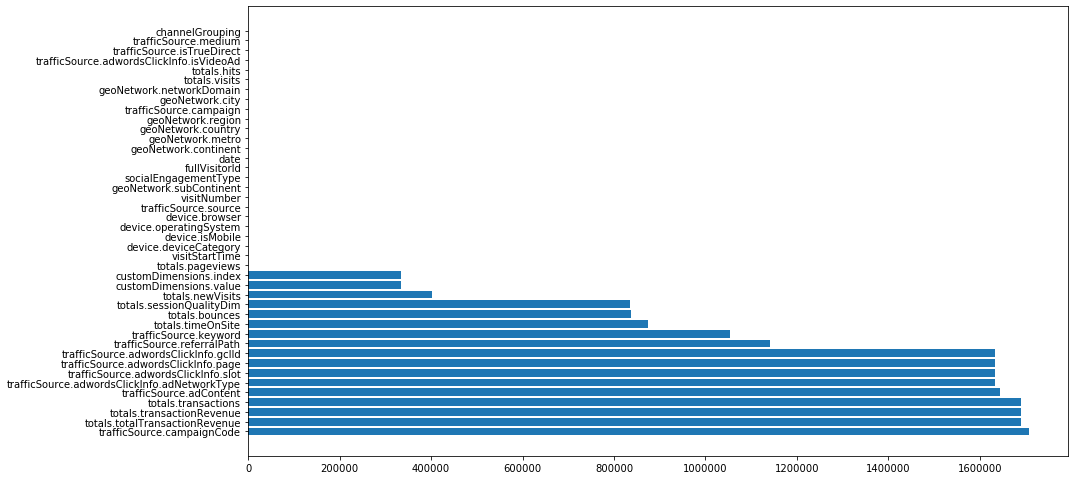

In [13]:
# Visualize missing values
plt.figure(figsize=[14.70, 8.27])
plt.barh(df_train.isna().sum().sort_values(ascending = False).index, 
         df_train.isna().sum().sort_values(ascending = False).values)
plt.show()

Remove `trafficSource.campaignCode` since there is only a non-missing value in this column and not available in test set.

In [14]:
# Remove columns
df_train.drop(columns = 'trafficSource.campaignCode', axis = 1, inplace = True)

As mentioned previously, there are some missing values recorded in some of the entries, namely, **(not set)**, **not available in demo dataset**, **(not provided)**, **unknown.unknown**, **/** and **(none)**. Thus, we will replace these values with np.nan.

In [15]:
# Replace all empty fields
def replace_empty(df):
    nulls = ['(not set)', 'not available in demo dataset', '(not provided)', 
             'unknown.unknown', '/', '(none)']
    
    for null in nulls:
        df.replace(null, np.nan, inplace = True)

In [16]:
replace_empty(df_train)

replace_empty(df_test)

Next, we will explore each column one by one.

1. `channelGrouping` **STRING**

> The Default Channel Group associated with an end user's session for this View.

2. `date` **STRING**

> The date of the session in YYYYMMDD format.

3. `fullVisitorId` **STRING**

> The unique visitor ID (also known as client ID).

4. `socialEngagementType` **STRING**

> Engagement type, either "Socially Engaged" or "Not Socially Engaged".

In [17]:
df_train["socialEngagementType"].unique()

array(['Not Socially Engaged'], dtype=object)

This column only contains one unique value which is 'Not Socially Engaged'. Therefore, it can be removed.

In [18]:
df_train.drop(columns = 'socialEngagementType', axis = 1, inplace = True)

df_test.drop(columns = 'socialEngagementType', axis = 1, inplace = True)

5. `visitNumber` **INTEGER**

> The session number for this user. If this is the first session, then this is set to 1.

In [19]:
df_train['visitNumber'] = df_train['visitNumber'].astype(np.int32)

df_test['visitNumber'] = df_test['visitNumber'].astype(np.int32)

6. `visitStartTime` **INTEGER**

> The timestamp (expressed as POSIX time).

Currently `date` and `visitStartTime` are string data type. To add more date features into the dataset, date related features are extracted from both `date` and `visitStartTime`.

In [20]:
# Define function to extract date features
def date_feature(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["visit_weekday"] = df['date'].dt.strftime('%A') #extracting week day
    df["visit_day"] = df['date'].dt.strftime("%d") # extracting day
    df["visit_month"] = df['date'].dt.strftime('%B') # extracting month
    df["visit_year"] = df['date'].dt.strftime("%Y") # extracting year
    df['visit_hour'] = df['visitStartTime'].apply(lambda x: 
                                                  str(datetime.fromtimestamp(x, pytz.timezone("UTC")).hour)) # extracting hour

In [21]:
# Apply function
date_feature(df_train)
date_feature(df_test)

7. `device.browser` **STRING**

> The browser used (e.g., "Chrome" or "Firefox").

In [22]:
df_train["device.browser"].unique()

array(['Firefox', 'Chrome', 'Safari', 'UC Browser', 'Internet Explorer',
       'Edge', 'Samsung Internet', 'Android Webview', 'Safari (in-app)',
       'Opera Mini', 'Opera', 'YaBrowser', 'Amazon Silk',
       'Mozilla Compatible Agent', 'Puffin', 'Maxthon', 'BlackBerry',
       'ADM', 'Coc Coc', 'MRCHROME', 'Android Browser',
       'Playstation Vita Browser', 'Nintendo Browser', 'Nokia Browser',
       'SeaMonkey', 'Lunascape', 'IE with Chrome Frame', 'ThumbSniper',
       'LYF_LS_4002_12', 'DESKTOP', 'Mozilla', 'Browser',
       'osee2unifiedRelease', 'Seznam', nan,
       ';__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a2b82;',
       'Apple-iPhone7C2',
       ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;',
       ';__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;',
       'DDG-Android-3.1.1', 'NokiaE52-1', 'Iron',
       '[Use default User-agent string] LIVRENPOCHE', 'Konqueror',
       ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;',
       'LYF_LS_4002_11', 'M5

There are some unknown browser type under the `device.browser` column. For the ease of analysis, these unknown browsers are categorized as bot.

In [23]:
# Define function to categorize device_browser
def categorize_browser(x):
    
    if 'Chrome' == x:
        return 'Chrome'
    elif 'Safari' == x:
        return 'Safari'
    elif 'Firefox' == x:
        return 'Firefox'
    elif 'Internet Explorer' == x:
        return 'Internet Explorer'
    elif 'Android Webview' == x:
        return 'Android Webview'
    elif 'Edge' == x:
        return 'Edge'
    elif 'Samsung Internet' == x:
        return 'Samsung Internet'
    elif 'Opera Mini' == x:
        return 'Opera Mini'
    elif 'Safari (in-app)' == x:
        return 'Safari (in-app)'
    elif 'Opera' == x:
        return 'Opera'
    elif 'UC Browser' == x:
        return 'UC Browser'
    elif 'YaBrowser' == x:
        return 'YaBrowser'
    elif 'Amazon Silk' == x:
        return 'Amazon Silk'
    elif 'Coc Coc' == x:
        return 'Coc Coc'
    elif 'Android Browser' == x:
        return 'Android Browser'
    elif 'Maxthon' == x:
        return 'Maxthon'
    elif 'Puffin' == x:
        return 'Puffin'
    elif 'BlackBerry' == x:
        return 'BlackBerry'
    elif 'Nintendo Browser' == x:
        return 'Nintendo Browser'
    elif 'Nokia Browser' == x:
        return 'Nokia Browser'
    elif 'Iron' == x:
        return 'Iron'
    elif 'SeaMonkey' == x:
        return 'SeaMonkey'
    elif 'Mozilla' == x:
        return 'Mozilla'
    elif 'Seznamr' == x:
        return 'Seznam'
    elif 'Playstation Vita Browser' == x:
        return 'Playstation Vita Browser'
    elif 'Lunascape' == x:
        return 'Lunascape'
    elif '+Simple Browser' == x:
        return '+Simple Browser'
    elif 'Konqueror' == x:
        return 'Konqueror'
    elif 'Android Runtime' == x:
        return 'Android Runtime'
    else:
        return 'Bot'

In [24]:
df_train['device.browser'] = df_train['device.browser'].apply(lambda x: categorize_browser(str(x)))

df_test['device.browser'] = df_test['device.browser'].apply(lambda x: categorize_browser(str(x)))

8. `device_operatingSystem` **STRING**

> The operating system of the device (e.g., "Macintosh" or "Windows").

In [25]:
df_train["device.operatingSystem"].unique()

array(['Windows', 'Chrome OS', 'Android', 'Macintosh', 'iOS', 'Linux',
       nan, 'Windows Phone', 'Samsung', 'Tizen', 'BlackBerry', 'OS/2',
       'Playstation Vita', 'Xbox', 'Nintendo Wii', 'Firefox OS',
       'Nintendo 3DS', 'Nintendo WiiU', 'SymbianOS', 'FreeBSD', 'Nokia',
       'OpenBSD', 'SunOS', 'NTT DoCoMo'], dtype=object)

9. `device.isMobile` **BOOLEAN**

> If the user is on a mobile device, this value is true, otherwise false.

10. `device.deviceCategory` **STRING**

> The type of device (Mobile, Tablet, Desktop).

In [26]:
df_train["device.deviceCategory"].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

11. `geoNetwork.continent` **STRING**

> The continent from which sessions originated, based on IP address.

In [27]:
df_train["geoNetwork.continent"].unique()

array(['Europe', 'Americas', 'Asia', 'Oceania', nan, 'Africa'],
      dtype=object)

12. `geoNetwork.subContinent` **STRING**

> The sub-continent from which sessions originated, based on IP address of the visitor.

In [28]:
df_train["geoNetwork.subContinent"].unique()

array(['Western Europe', 'Northern America', 'Western Asia',
       'Central America', 'Northern Europe', 'Southern Asia',
       'Southeast Asia', 'Eastern Europe', 'South America',
       'Eastern Asia', 'Southern Europe', 'Australasia', 'Central Asia',
       nan, 'Northern Africa', 'Eastern Africa', 'Southern Africa',
       'Western Africa', 'Caribbean', 'Middle Africa', 'Melanesia',
       'Micronesian Region', 'Polynesia'], dtype=object)

13. `geoNetwork.country` **STRING**

> The country from which sessions originated, based on IP address.

In [29]:
df_train["geoNetwork.country"].unique()

array(['Germany', 'United States', 'Turkey', 'Mexico', 'United Kingdom',
       'Denmark', 'Netherlands', 'Sweden', 'Canada', 'India', 'Belgium',
       'Philippines', 'Slovakia', 'Brazil', 'Japan', 'Taiwan', 'Peru',
       'Ireland', 'Norway', 'Romania', 'Russia', 'Italy', 'New Zealand',
       'Czechia', 'Serbia', 'Argentina', 'Australia', 'Hong Kong',
       'Indonesia', 'Singapore', 'Kazakhstan', 'Thailand', 'Ecuador',
       'Switzerland', 'Spain', 'France', 'Malaysia', 'Poland', 'Bulgaria',
       'Jordan', 'China', 'Pakistan', nan, 'Israel', 'Vietnam',
       'Bangladesh', 'Greece', 'Algeria', 'Georgia', 'Ukraine',
       'South Korea', 'Austria', 'Ethiopia', 'Colombia', 'Sudan', 'Egypt',
       'United Arab Emirates', 'Panama', 'Portugal', 'Latvia', 'Chile',
       'Belarus', 'South Africa', 'El Salvador', 'Nigeria', 'Venezuela',
       'Sri Lanka', 'Estonia', 'Croatia', 'Myanmar (Burma)', 'Lithuania',
       'Armenia', 'Puerto Rico', 'Saudi Arabia', 'Dominican Republic',
     

14. `geoNetwork.region` **STRING**

> The region from which sessions originate, derived from IP addresses. In the U.S., a region is a state, such as New York.

In [30]:
df_train["geoNetwork.region"].unique()

array([nan, 'California', 'England', 'Mexico City', 'Nevada', 'Brussels',
       'Tokyo', 'County Dublin', 'Maharashtra', 'Istanbul', 'Ontario',
       'Telangana', 'Pennsylvania', 'Michigan', 'Massachusetts',
       'British Columbia', 'Madhya Pradesh', 'Quebec', 'New South Wales',
       'Jakarta', 'New York', 'State of Sao Paulo', 'Washington',
       'District of Columbia', 'Chiayi County', 'Delhi', 'Karnataka',
       'Bangkok', 'Aragon', 'Zurich', 'Masovian Voivodeship', 'Texas',
       'Georgia', 'Illinois', 'Tamil Nadu', 'Sindh', 'Lombardy',
       'Federal Territory of Kuala Lumpur', 'Saint Petersburg',
       'Tennessee', 'Hanoi', 'Taipei City', 'Madrid', 'Berlin',
       'Ho Chi Minh City', 'Victoria', 'Seoul', 'Ile-de-France', 'Lisbon',
       'Bogota', 'New Taipei City', 'Stockholm County',
       'Western Province', 'Lagos', 'Riyadh Province', 'Dubai',
       'Colorado', 'Buenos Aires', 'Lima Region',
       'Santiago Metropolitan Region', 'Dublin City', 'North Holland',


15. `geoNetwork.metro` **STRING**

> The Designated Market Area (DMA) from which sessions originate.

In [31]:
df_train["geoNetwork.metro"].unique()

array([nan, 'San Francisco-Oakland-San Jose CA', 'London', 'JP_KANTO',
       'Los Angeles CA', 'Pittsburgh PA', 'Detroit MI',
       'Boston MA-Manchester NH', 'New York NY', 'Seattle-Tacoma WA',
       'Washington DC (Hagerstown MD)', 'San Antonio TX', 'Atlanta GA',
       'Chicago IL', 'Dallas-Ft. Worth TX', 'Philadelphia PA',
       'San Diego CA', 'Austin TX', 'Nashville TN', 'Houston TX',
       'Yorkshire', 'Denver CO', 'Roanoke-Lynchburg VA',
       'La Crosse-Eau Claire WI', 'Charlotte NC', 'Butte-Bozeman MT',
       'JP_KINKI', 'Portland OR', 'Phoenix AZ', 'Columbus OH',
       'Minneapolis-St. Paul MN', 'North West', 'Jacksonville FL',
       'Meridian (exc. Channel Islands)',
       'Orlando-Daytona Beach-Melbourne FL', 'Las Vegas NV', 'Midlands',
       'Springfield-Holyoke MA', 'Green Bay-Appleton WI',
       'Harlingen-Weslaco-Brownsville-McAllen TX', 'Indianapolis IN',
       'Chico-Redding CA', 'Norfolk-Portsmouth-Newport News VA',
       'East Of England', 'Lansing MI

16. `geoNetwork.city` **STRING**

> Users' city, derived from their IP addresses or Geographical IDs.

17. `geoNetwork.networkDomain` **STRING**

> The domain name of user's ISP, derived from the domain name registered to the ISP's IP address.

18. `totals.visits` **INTEGER**

> The number of sessions (for convenience). This value is 1 for sessions with interaction events. The value is null if there are no interaction events in the session.

In [32]:
df_train["totals.visits"].unique()

array(['1'], dtype=object)

This column can be ignored because it has only 1 unique value.

In [33]:
df_train.drop(columns = 'totals.visits', axis = 1, inplace = True)

df_test.drop(columns = 'totals.visits', axis = 1, inplace = True)

19. `totals.hits` **INTEGER**

> Total number of hits within the session.

Both `totals.hits` and `totals.pageviews` are similar data. So, `totals.hits` is dropped.

In [34]:
df_train['totals.hits'] = df_train['totals.hits'].astype(np.int32)

df_test['totals.hits'] = df_test['totals.hits'].astype(np.int32)

20. `totals.pageviews` **INTEGER**

> Total number of pageviews within the session.

In [35]:
# Convert totals_pageviews into a integer data type and fill na value with 0
def clean_pageviews(df):
    df['totals.pageviews'].fillna(0, inplace = True)
    df['totals.pageviews'] = df['totals.pageviews'].astype(np.int32)

# Apply function
clean_pageviews(df_train)

clean_pageviews(df_test)

21. `totals.bounces` **INTEGER**

> Total bounces (for convenience). For a bounced session, the value is 1, otherwise it is null.

In [36]:
# convert totals_bounces into a integer data type and fill na value with 0
def clean_bounces(df):
    df['totals.bounces'].fillna(0, inplace = True)
    df['totals.bounces'] = df['totals.bounces'].astype(np.int32)

# Apply function
clean_bounces(df_train)

clean_bounces(df_test)

22. `totals.newVisits` **INTEGER**

> Total number of new users in session (for convenience). If this is the first visit, this value is 1, otherwise it is null.

In [37]:
# convert totals_newVisits into a integer data type and fill na value with 0
def clean_newVisits(df):
    df['totals.newVisits'].fillna(0, inplace = True)
    df['totals.newVisits'] = df['totals.newVisits'].astype(np.int32)
    
# Apply function
clean_newVisits(df_train)

clean_newVisits(df_test)

23. `totals.sessionQualityDim` **INTEGER**

> An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting. A value of 0 indicates that Session Quality is not calculated for the selected time range.

In [38]:
# convert sessionQualityDim into a integer data type and fill na value with 0
def clean_sessionQualityDim(df):
    df['totals.sessionQualityDim'].fillna(0, inplace = True)
    df['totals.sessionQualityDim'] = df['totals.sessionQualityDim'].astype(np.int32)

# Apply function
clean_sessionQualityDim(df_train)

clean_sessionQualityDim(df_test)

24. `totals.timeOnSite` **INTEGER**

> Total time of the session expressed in seconds.

In [39]:
# convert totals_timeOnSite into a integer data type and fill na value with 0
def clean_timeOnSite(df):
    df['totals.timeOnSite'].fillna(0, inplace = True)
    df['totals.timeOnSite'] = df['totals.timeOnSite'].astype(np.int32)

# Apply function
clean_timeOnSite(df_train)

clean_timeOnSite(df_test)

25. `totals.transactions` **INTEGER**

> Total number of ecommerce transactions within the session.

In [40]:
df_train['totals.transactions'].fillna(0, inplace = True)
df_train['totals.transactions'] = df_train['totals.transactions'].astype(np.int32)

df_test['totals.transactions'].fillna(0, inplace = True)
df_test['totals.transactions'] = df_test['totals.transactions'].astype(np.int32)

26. `totals.transactionRevenue` **FLOAT**

> This field is deprecated. Use "totals.totalTransactionRevenue" instead

In [41]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype('float')

df_test['totals.transactionRevenue'] = df_test['totals.transactionRevenue'].astype('float')

27. `totals.totalTransactionRevenue` **FLOAT**

> Total transaction revenue, expressed as the value passed to Analytics multiplied by 10^6 (e.g., 2.40 would be given as 2400000).

In [42]:
df_train['totals.totalTransactionRevenue'] = df_train['totals.totalTransactionRevenue'].astype('float')

df_test['totals.totalTransactionRevenue'] = df_test['totals.totalTransactionRevenue'].astype('float')

28. `trafficSource.campaign` **STRING**

> The campaign value. Usually set by the utm_campaign URL parameter.

29. `trafficSource.source` **STRING**

> The campaign value. Usually set by the utm_campaign URL parameter.

30. `trafficSource.medium` **STRING**

> The medium of the traffic source. Could be "organic", "cpc", "referral", or the value of the utm_medium URL parameter.

31. `trafficSource.keyword` **STRING**

> If this was a search results page, this is the keyword entered.

In [43]:
# https://shop.googlemerchandisestore.com/
# 6qEhsCssdK0z36ri = YouTube Small Sticker Sheet
# https://shop.googlemerchandisestore.com/Google+Redesign/Accessories/YouTube+Small+Sticker+Sheet
# 1hZbAqLCbjwfgOH7 = Google
# https://shop.googlemerchandisestore.com/asearch.html?vid=20160512512&key=1hZbAqLCbjwfgOH7&keyword=1hZbAqLCbjwfgOH7
import re

googleKeywords = ['google', 'goo', 'gle',('1hZbAqLCbjwfgOH7').lower()]
youtubeKeywords = ['youtube', 'yt', 'yotube', 'yutube', ('6qEhsCssdK0z36ri').lower()]
androidKeywords = ['android']
autoMatchingKeywords = ['automatic matching']
userTargetingKeywords = ['user vertical targeting']
remarketingKeywords = ['remarketing/content targeting']
doubleClickAdExchangeKeywords = ['doubleclick']

# Define function to categorize trafficSource_keyword
def categorize_trafficSource_keyword(x):

    if pd.isna(x):
        return 
    else:
        x = str(x).lower()
       
        isGoogle = re.findall(r"(?=("+'|'.join(googleKeywords)+r"))",x)
        isYoutube = re.findall(r"(?=("+'|'.join(youtubeKeywords)+r"))",x)
        isAndroid = re.findall(r"(?=("+'|'.join(androidKeywords)+r"))",x)
        isAutoMatching = re.findall(r"(?=("+'|'.join(autoMatchingKeywords)+r"))",x)
        isUserTargeting = re.findall(r"(?=("+'|'.join(userTargetingKeywords)+r"))",x)
        isRemarketing = re.findall(r"(?=("+'|'.join(remarketingKeywords)+r"))",x)
        isDoubleClickAdExchange = re.findall(r"(?=("+'|'.join(doubleClickAdExchangeKeywords)+r"))",x)
        
        if isGoogle:
            keyword = 'Google'
        elif isYoutube:
            keyword = 'Youtube'
        elif isAndroid:
            keyword = 'Android'
        elif isAutoMatching:
            keyword = '(automatic matching)'
        elif isUserTargeting:
            keyword = '(User vertical targeting)'
        elif isRemarketing:
            keyword = '(Remarketing/Content targeting)'
        elif isDoubleClickAdExchange:
            keyword = 'DoubleClick Ad Exchange'
        else:
            keyword = 'Other'
            
        return keyword

In [44]:
# Apply Function
df_train['trafficSource.keyword'] = df_train['trafficSource.keyword'].apply(categorize_trafficSource_keyword)

df_test['trafficSource.keyword'] = df_test['trafficSource.keyword'].apply(categorize_trafficSource_keyword)

32. `trafficSource_referralPath` **STRING**

> If trafficSource.medium is "referral", then this is set to the path of the referrer. (The host name of the referrer is in trafficSource.source.)

33. `trafficSource_isTrueDirect` **BOOLEAN**

> True if the source of the session was Direct (meaning the user typed the name of your website URL into the browser or came to your site via a bookmark), This field will also be true if 2 successive but distinct sessions have exactly the same campaign details. Otherwise NULL.

34. `trafficSource_adwordsClickInfo.gclId` **STRING**

> The Google Click ID.

For Google Ads info, create new column `googleAds` and if `adwordsClickInfo.gclId` is not null, fill it with **1** otherwise **0**.

In [45]:
# Define function to categorize Google Ads info
def categorize_adwordsClickInfo(x):
    
    if pd.isna(x):
        return '1'
    else:
        return '0'

In [46]:
df_train['googleAds'] = df_train['trafficSource.adwordsClickInfo.gclId'].apply(categorize_adwordsClickInfo)

df_test['googleAds'] = df_test['trafficSource.adwordsClickInfo.gclId'].apply(categorize_adwordsClickInfo)

Remove unused columns for Google Ads info.

In [47]:
# Drop unused/nan columns
unused_cols = ['trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 
               'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType',
               'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent']

df_train.drop(unused_cols, axis = 1, inplace = True)

df_test.drop(unused_cols, axis = 1, inplace = True)

35. `customDimensions.index` **INTEGER**

> The index of the custom dimension.

36. `customDimensions.value` **STRING**

> The value of the custom dimension.

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 39 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   channelGrouping                 object        
 1   date                            datetime64[ns]
 2   fullVisitorId                   object        
 3   visitNumber                     int32         
 4   visitStartTime                  int64         
 5   device.browser                  object        
 6   device.operatingSystem          object        
 7   device.isMobile                 bool          
 8   device.deviceCategory           object        
 9   geoNetwork.continent            object        
 10  geoNetwork.subContinent         object        
 11  geoNetwork.country              object        
 12  geoNetwork.region               object        
 13  geoNetwork.metro                object        
 14  geoNetwork.city                 object        
 15

In [49]:
df_train.to_csv("df_train.csv", index = False)
df_test.to_csv("df_test.csv", index = False)

<a id='eda'></a>
## 3. Exploratory Data Analysis

**Notes:**
> `totals.totalTransactionRevenue` is preferred to be visualized in this part while `totals.transactionRevenue` will be used for prediction. A [thread](https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/71779) in Kaggle to discuss `transactionRevenue` vs `totalTransactionRevenue`. The demonstration of all the revenue values are divided by 10^6 for better visualization.

In [5]:
# Set sns style
sns.set(style="darkgrid")

# Removing the rainbow colors and use only ONE color
base_color = sns.color_palette()[0]

### 3.1. How many of the visits will result in transaction (buying)

In [6]:
print('There is only {}% completed transaction in dataset.'\
      .format(round(len(df_train[df_train['totals.totalTransactionRevenue'] > 0]) / df_train.shape[0] * 100, 2)))

There is only 1.08% completed transaction in dataset.


- Only 1% of the visits convert into transaction (buying)

### 3.2. A deeper look on visit frequency and number of transaction (buying)

In [7]:
# Aggregate by visitor ID to get frequency of visit
visitFreq_agg = df_train.groupby('fullVisitorId').agg(frequency = ('fullVisitorId', 'count') , 
                                                      transactions = ('totals.transactions', 'sum'))

visitFreq_agg['visitRange'] = pd.cut(visitFreq_agg['frequency'], [-1, 1, 2, 3, 6, 10, 20, 40, 80, 500],
                                     labels = ['1', '2', '3', '4-6', '7-10', '11-20', '21-40', '41-80', '81-500'])

visitFreq_agg = visitFreq_agg.groupby('visitRange').agg(visit_frequency = ('frequency','count'),
                                                        no_of_transactions =('transactions','sum'))
visitFreq_agg['frequency_%'] = (visitFreq_agg['visit_frequency']/sum(visitFreq_agg['visit_frequency'])).map("{:.2%}".format)
visitFreq_agg['transactions_%'] = (visitFreq_agg['no_of_transactions']/sum(visitFreq_agg['no_of_transactions'])).map("{:.2%}".format)


visitFreq_agg[['visit_frequency','frequency_%','no_of_transactions','transactions_%']]

,visit_frequency,frequency_%,no_of_transactions,transactions_%
visitRange,,,,
1,1138049,85.97%,5091,26.34%
2,115694,8.74%,3853,19.93%
3,34104,2.58%,2590,13.40%
4-6,26227,1.98%,3984,20.61%
7-10,6392,0.48%,1924,9.95%
11-20,2505,0.19%,1162,6.01%
21-40,571,0.04%,549,2.84%
41-80,135,0.01%,73,0.38%
81-500,53,0.00%,104,0.54%


- Most visitors (85.97%) only visit the website once
- For the visitors that visit the site for 4 - 6 times, they have the highest probability of buy something, \
although they only account for 1.98% of total visitors, they contribute 20.61% of the total transactions (buying)

In [8]:
purchaseFreq_agg = df_train.groupby('fullVisitorId').agg(frequency = ('totals.transactions', 'sum'))
purchaseFreq_agg['purchaseRange'] = pd.cut(purchaseFreq_agg['frequency'], [-1, 0, 1, 2, 3, 6, 15, 40],
                                        labels = ['0', '1', '2', '3', '4-6', '7-15', '16-40'])
purchaseFreq_agg = purchaseFreq_agg.groupby('purchaseRange').agg('count')
purchaseFreq_agg

,frequency
purchaseRange,
0,1307559
1,14336
2,1293
3,304
4-6,177
7-15,52
16-40,9


- For the visitor that buying thing most of them only buy one thing 

#### Visualize the visit frequency and purchase frequency
(after removing visit freq : 1 and purchaseRange : 0 & 1)

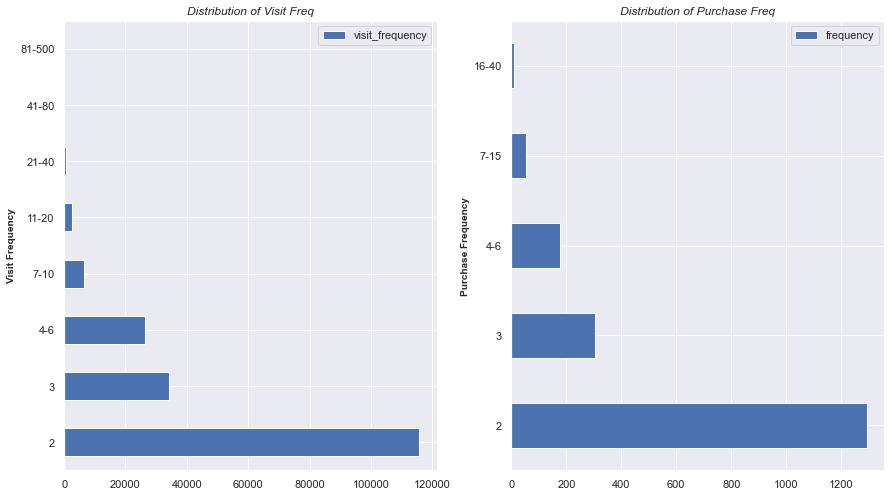

In [9]:
fig,axes = plt.subplots(1,2,figsize = (14.70, 8.27))
visitFreq_agg[1:][['visit_frequency']].plot.barh(ax = axes[0])

axes[0].set_title('Distribution of Visit Freq', fontsize = 12, style = 'italic')
axes[0].set_ylabel('Visit Frequency', fontsize = 10, weight = 'bold');

purchaseFreq_agg[2:].plot.barh(ax = axes[1])

axes[1].set_title('Distribution of Purchase Freq', fontsize = 12, style = 'italic')
axes[1].set_ylabel('Purchase Frequency', fontsize = 10, weight = 'bold');

### 3.3. Do the number of visits and purchase (transaction) effected by seasonality?

In [10]:
GData = df_train.groupby('date').agg(visitFreq = ('fullVisitorId', 'count'),
                                     newVisit = ('totals.newVisits', 'sum'),
                                     transaction = ('totals.transactions', 'sum'))

GData = GData.reset_index()

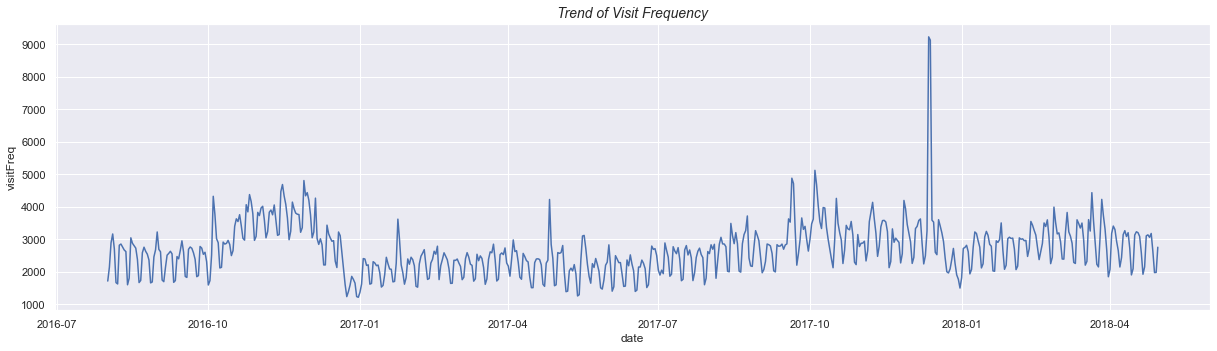

In [11]:
## Graph for visit frequency

fig, ax =  plt.subplots(1, 1, figsize = (20.70, 5.27))
sns.lineplot(x="date", y="visitFreq", data=GData)

ax.set_title('Trend of Visit Frequency', fontsize = 14, style = 'italic');

In [12]:
GData.nlargest(10,['visitFreq'])

,date,visitFreq,newVisit,transaction
498,2017-12-12,9234,8159,30
499,2017-12-13,9131,7400,48
429,2017-10-04,5122,3822,35
415,2017-09-20,4880,3846,33
119,2016-11-28,4807,3834,73
416,2017-09-21,4715,3637,33
106,2016-11-15,4685,3837,33
430,2017-10-05,4679,3487,25
105,2016-11-14,4466,3558,39
121,2016-11-30,4435,3498,58


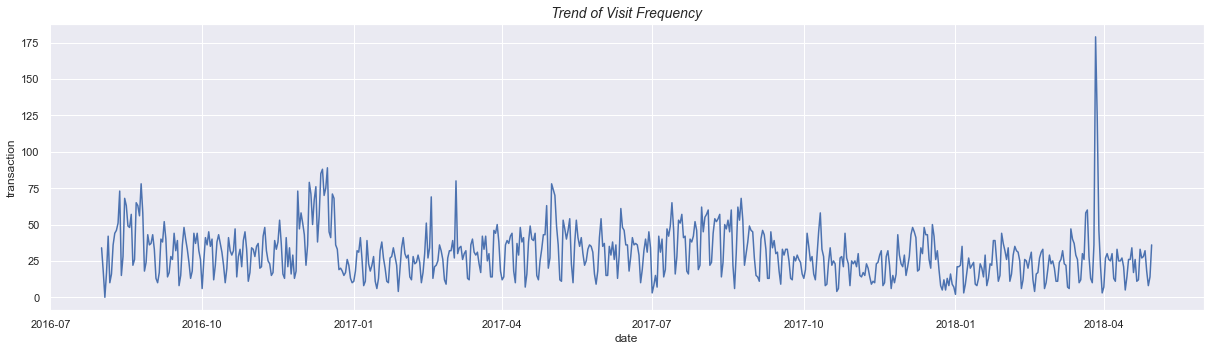

In [13]:
## Graph for sum of transaction (buying)

fig, ax =  plt.subplots(1, 1, figsize = (20.70, 5.27))
sns.lineplot(x="date", y="transaction", data=GData)

ax.set_title('Trend of Visit Frequency', fontsize = 14, style = 'italic'); 

In [14]:
GData.nlargest(10,['transaction'])

,date,visitFreq,newVisit,transaction
603,2018-03-27,4227,3057,179
604,2018-03-28,3724,2576,123
137,2016-12-16,2956,2106,89
134,2016-12-13,3166,2256,88
133,2016-12-12,3433,2464,85
215,2017-03-04,1753,1396,80
126,2016-12-05,4265,3217,79
24,2016-08-25,2539,1921,78
273,2017-05-01,2588,1906,78
130,2016-12-09,2830,1967,76


### Noted something weird? Let compared them in s single graph

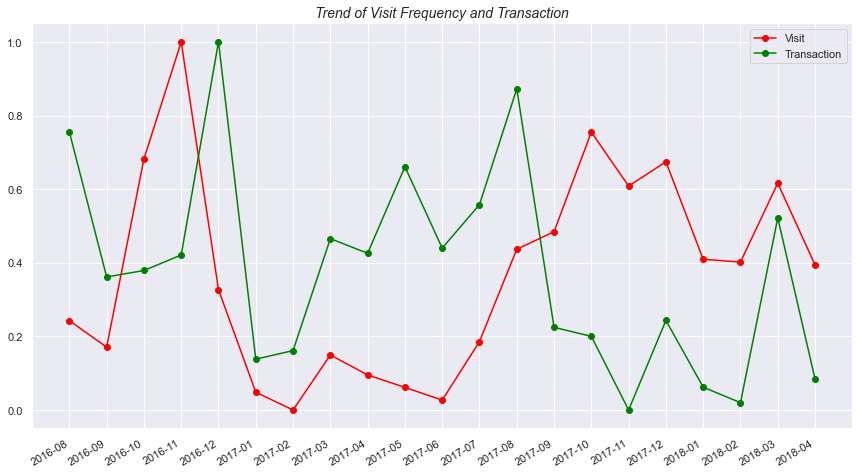

In [15]:
df_train['yearMonth'] = df_train['date'].dt.to_period('M')

monthly_visit = df_train.groupby('yearMonth').agg(visitFreq = ('fullVisitorId', 'count'),
                                                  transaction = ('totals.transactions', 'sum'))

monthly_visit.reset_index(inplace = True)
monthly_visit['yearMonth'] = monthly_visit['yearMonth'].astype(str)

min_max_scaler = MinMaxScaler()
monthly_visit['visitFreq'] = min_max_scaler.fit_transform(monthly_visit[['visitFreq']])
monthly_visit['transaction'] = min_max_scaler.fit_transform(monthly_visit[['transaction']])

fig, ax =  plt.subplots(1, 1, figsize = (14.70, 8.27))

ax.plot_date(monthly_visit['yearMonth'], monthly_visit["visitFreq"], color="red", label="Visit", linestyle="-")
ax.plot_date(monthly_visit['yearMonth'], monthly_visit["transaction"], color="green", label="Transaction", linestyle="-")
ax.legend()
ax.set_title('Trend of Visit Frequency and Transaction', fontsize = 14, style = 'italic'); 
plt.gcf().autofmt_xdate();

- Bingo, the period with most visit != the period with highest selling

### 3. When Gstore gain most of the profit

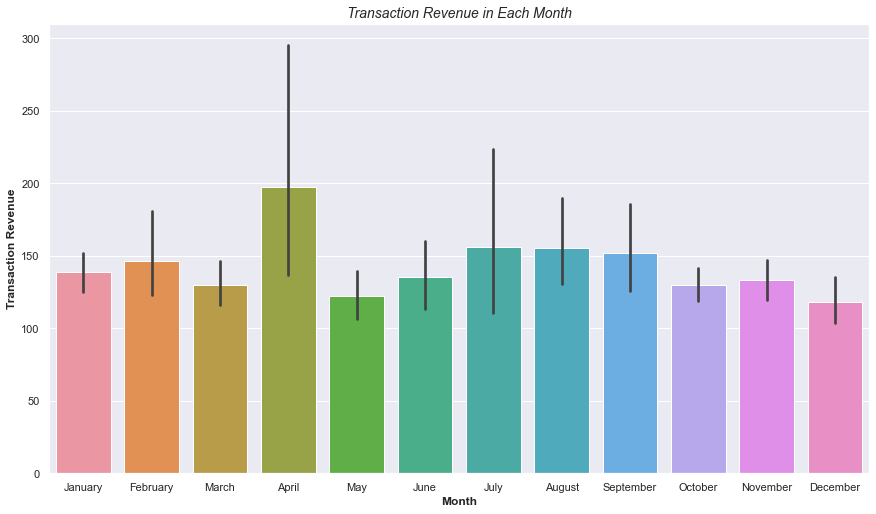

In [16]:
# Define order of month for better visualization
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(14.70, 8.27))

# Set sns style
sns.set(style="darkgrid")

# Removing the rainbow colors and use only ONE color
base_color = sns.color_palette()[0]

sns.barplot(data = df_train,
            x = 'visit_month',
            y = (df_train['totals.totalTransactionRevenue'] / 10**6),
            order = month_order)
plt.title("Transaction Revenue in Each Month", fontsize = 14, style = 'italic')
plt.xlabel("Month", fontsize = 12, weight = 'bold')
plt.ylabel("Transaction Revenue", fontsize = 12, weight = 'bold');

- Revenue peak on April

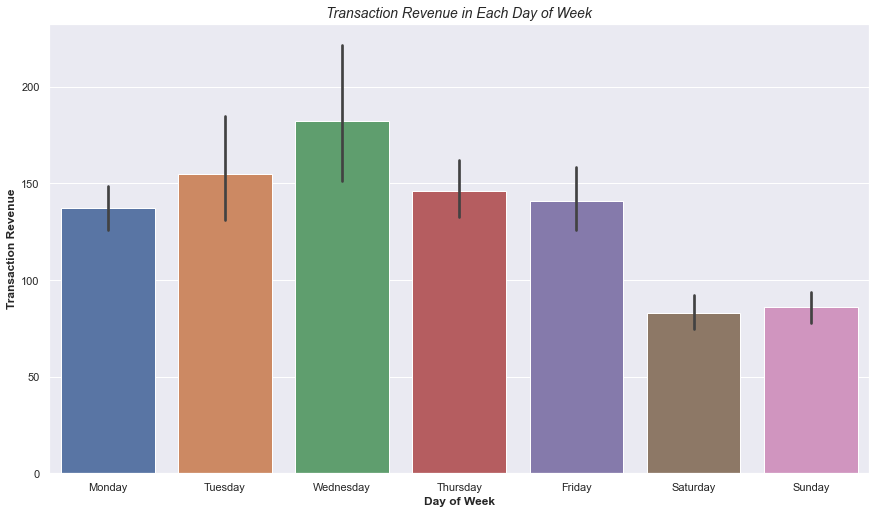

In [17]:
# Define order of day for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14.70, 8.27))
sns.barplot(data = df_train,
            x = 'visit_weekday',
            y = (df_train['totals.totalTransactionRevenue'] / 10**6),
            order = day_order)
plt.title("Transaction Revenue in Each Day of Week", fontsize = 14, style = 'italic')
plt.xlabel("Day of Week", fontsize = 12, weight = 'bold')
plt.ylabel("Transaction Revenue", fontsize = 12, weight = 'bold');

- Sales concentrated on Weekday? Interesting

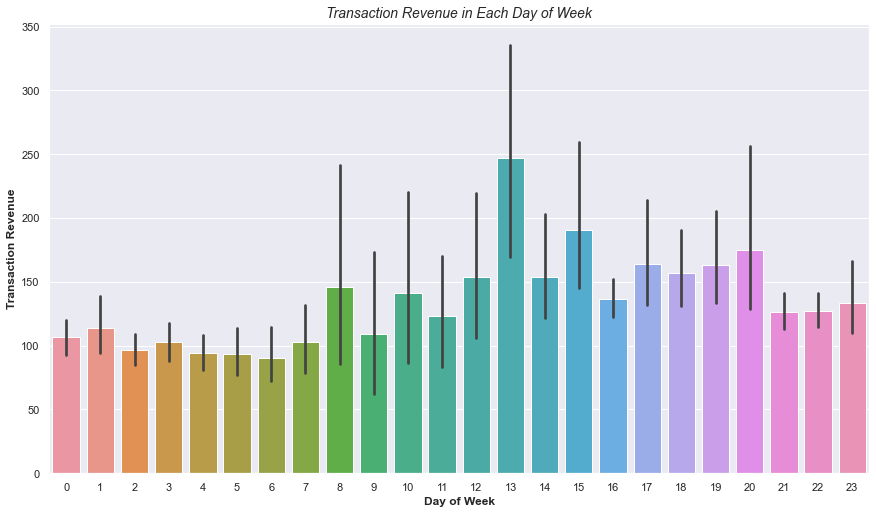

In [18]:
plt.figure(figsize=(14.70, 8.27))
sns.barplot(data = df_train,
            x = 'visit_hour',
            y = (df_train['totals.totalTransactionRevenue'] / 10**6))
plt.title("Transaction Revenue in Each Day of Week", fontsize = 14, style = 'italic')
plt.xlabel("Day of Week", fontsize = 12, weight = 'bold')
plt.ylabel("Transaction Revenue", fontsize = 12, weight = 'bold');

- Most revenue gain by visit in 13:00 (1:00pm), ok some story appeared

### 3.4. What device visitor use to visit Gstore 

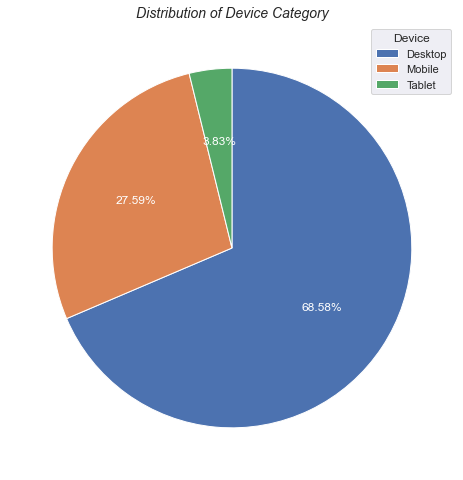

In [19]:
device = df_train['device.deviceCategory'].value_counts()

plt.figure(figsize=[14.70, 8.27])
plt.pie(device, labels = device.index, startangle = 90, autopct= '%1.2f%%', counterclock = False, textprops={'color':'white'});
plt.legend(['Desktop', 'Mobile', 'Tablet'],
           title='Device', 
           loc='upper right')
plt.title('Distribution of Device Category', fontsize = 14,  style ='italic');

### 3.5 The location of the buyer

#### Get a Visualization on the location (country)

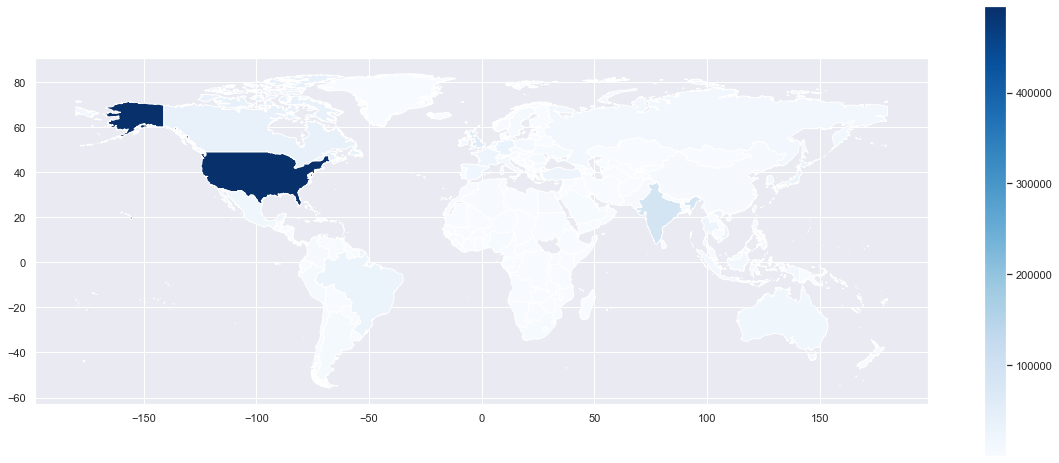

In [22]:
# https://www.naturalearthdata.com/downloads/50m-cultural-vectors/50m-admin-0-countries-2/
# Import geolocation shape file

import geopandas as gpd
import pycountry

world = gpd.read_file('map/ne_50m_admin_0_countries.shp')
#world

country_visitor = df_train.groupby(['geoNetwork.country', 'fullVisitorId']).size().reset_index()
country_visitor = country_visitor.groupby(['geoNetwork.country']).agg(count = ('fullVisitorId', 'count')).reset_index()
country_visitor.sort_values(by = 'count', ascending = False)

input_countries = country_visitor['geoNetwork.country']
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in input_countries]
country_visitor['countryCode'] = codes


# Manual fix unknowmn country code
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Antigua & Barbuda', 'countryCode'] = 'ATG' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Bolivia', 'countryCode'] = 'BOL' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Bosnia & Herzegovina', 'countryCode'] = 'BIH' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'British Virgin Islands', 'countryCode'] = 'VGB' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Brunei', 'countryCode'] = 'BRU' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Cape Verde']['countryCode'] == 'CPV' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Caribbean Netherlands', 'countryCode'] = 'BQ' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Congo - Brazzaville', 'countryCode'] = 'COG' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Congo - Kinshasa', 'countryCode'] = 'COD' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Côte d’Ivoire', 'countryCode'] = 'CIV' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Iran', 'countryCode'] = 'IRN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Kosovo', 'countryCode'] = 'KOS' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Laos', 'countryCode'] = 'LAO' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Macau', 'countryCode'] = 'MAC' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Macedonia (FYROM)', 'countryCode'] = 'MKD' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Micronesia', 'countryCode'] = 'FSM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Palestine', 'countryCode'] = 'PSE' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Russia', 'countryCode'] = 'RUS' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Sint Maarten', 'countryCode'] = 'SXM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'South Korea', 'countryCode'] = 'KOR' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Barthélemy', 'countryCode'] = 'BLM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Helena', 'countryCode'] = 'SHN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Kitts & Nevis', 'countryCode'] = 'KNA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Lucia', 'countryCode'] = 'LCA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Martin', 'countryCode'] = 'MAF' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Pierre & Miquelon', 'countryCode'] = 'SPM' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'St. Vincent & Grenadines', 'countryCode'] = 'VCT' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Swaziland', 'countryCode'] = 'SWZ' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Syria', 'countryCode'] = 'SYR' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'São Tomé & Príncipe', 'countryCode'] = 'STP' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Taiwan', 'countryCode'] = 'TWN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Tanzania', 'countryCode'] = 'TZA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Trinidad & Tobago', 'countryCode'] = 'TTO' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Turks & Caicos Islands', 'countryCode'] = 'TCA' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'U.S. Virgin Islands', 'countryCode'] = 'VIR' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Venezuela', 'countryCode'] = 'VEN' 
country_visitor.loc[country_visitor['geoNetwork.country'] == 'Vietnam', 'countryCode'] = 'VNM'

merged = world.merge(country_visitor, left_on='ADM0_A3', right_on='countryCode')

# Plot using geopandas
colors = 9
cmap = 'Blues'
figsize=(20, 8.27)
merged.plot(column='count', cmap=cmap, figsize=figsize, k=colors, legend=True);

#### Ok into detail figure

In [23]:
country = df_train.groupby('geoNetwork.country').agg(visitFreq = ('fullVisitorId', 'count'),
                                                     no_of_transactions =('totals.transactions','sum'))
country['visit_Freq%'] = (country['visitFreq']/sum(country['visitFreq'])).map("{:.2%}".format)
country['trans_Freq%'] = (country['no_of_transactions']/sum(country['no_of_transactions'])).map("{:.2%}".format)

country = country[['visitFreq','visit_Freq%','no_of_transactions','trans_Freq%']]


country.sort_values(by=['visitFreq'],ascending = False).head(10)

,visitFreq,visit_Freq%,no_of_transactions,trans_Freq%
geoNetwork.country,,,,
United States,717217,42.05%,18349,94.96%
India,105317,6.17%,18,0.09%
United Kingdom,73341,4.30%,28,0.14%
Canada,51057,2.99%,327,1.69%
Germany,38516,2.26%,12,0.06%
Japan,36637,2.15%,23,0.12%
Brazil,35432,2.08%,21,0.11%
Vietnam,34869,2.04%,0,0.00%
France,32289,1.89%,16,0.08%


- Most of the visits comes from united state, and nearly 95% of the transaction (buying) is come from United State

#### Now more question, which part of the United State?

In [24]:
city = df_train.groupby('geoNetwork.city').agg(visitFreq = ('fullVisitorId', 'count'),
                                                  no_of_transactions =('totals.transactions','sum'))
city['visit_Freq%'] = (city['visitFreq']/sum(country['visitFreq'])).map("{:.2%}".format)
city['trans_Freq%'] = (city['no_of_transactions']/sum(country['no_of_transactions'])).map("{:.2%}".format)

city = city[['visitFreq','visit_Freq%','no_of_transactions','trans_Freq%']]


city.sort_values(by=['visitFreq'],ascending = False).head(10)

### since geoNetwork.city have more NA compared to geoNetwork.country we divide the total visitfreq and transaction of a city
### with the sum of geoNetwork.country figure to get the idea of percentage.

,visitFreq,visit_Freq%,no_of_transactions,trans_Freq%
geoNetwork.city,,,,
Mountain View,74110,4.34%,2156,11.16%
New York,49460,2.90%,2527,13.08%
San Francisco,36960,2.17%,1180,6.11%
Sunnyvale,27923,1.64%,883,4.57%
London,23622,1.38%,19,0.10%
San Jose,20141,1.18%,393,2.03%
Los Angeles,17038,1.00%,491,2.54%
Chicago,15143,0.89%,697,3.61%
Bangkok,12468,0.73%,5,0.03%


- Interesting info: Mountain View,Sunnyvale and San Jose is cities loacted inside silicon valley, together they account for 7.5% of the total visit and 18% of the total transaction (buying) of Gstore

## Info we get from exploratory analysis

- Most of the visitors (99%) only view and not buy
- Main customer of the sites come from United State, and the biggest group comes from silicon valley (where the company of google located)
- Most buying occured on weekdays and visit time around 1:00pm, possible is a lunch (rest time) of office
- The April and Oct-Dec is some hot season the sites been visited and buying occured \
(maybe due to gifts of easter day (April) and Chrismas (December)?)

### And last we have a view on distribution of figures (transaction revenue) we going to predict
- we are going to predict target, target = log(1+sum(per user transactions)) 
- we will look at the pdf of target to understand more about its distribution.

Transaction Revenue Min Value:  1.2
Transaction Revenue Mean Value:  142.81666954736957
Transaction Revenue Median Value:  52.79
Transaction Revenue Max Value:  47082.06


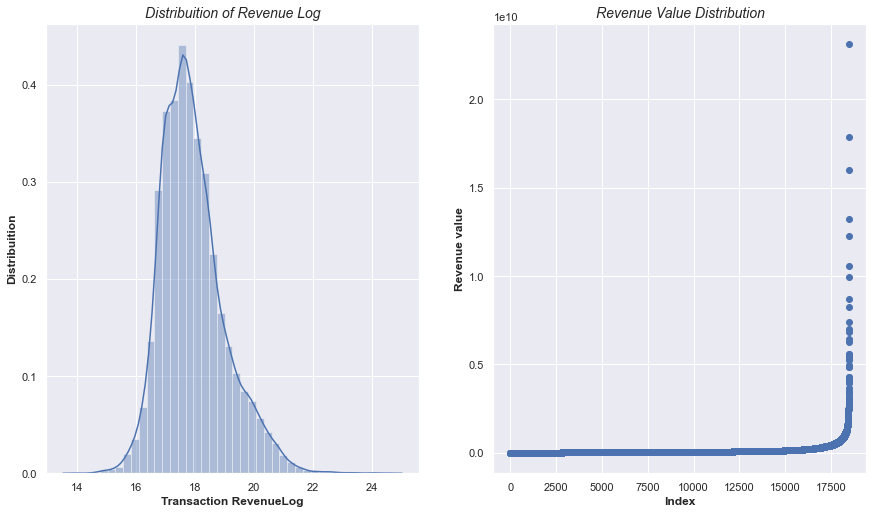

In [25]:
# Printing some statistics of our data
print("Transaction Revenue Min Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].min() / 10**6) # printing the min value
print("Transaction Revenue Mean Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].mean() / 10**6) # mean value
print("Transaction Revenue Median Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].median() / 10**6) # median value
print("Transaction Revenue Max Value: ", 
      df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"].max() / 10**6) # the max value

# seting the figure size of our plots
plt.figure(figsize=(14.70, 8.27))

# Subplot allow us to plot more than one 
# in this case, will be create a subplot grid of 2 x 1
plt.subplot(1,2,1)
# seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
# also, we will set the number of bins and if we want or not kde on our histogram
ax = sns.distplot(np.log(df_train[df_train['totals.totalTransactionRevenue'] > 0]["totals.totalTransactionRevenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize = 12, weight = 'bold') #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize = 12, weight = 'bold') #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue Log", fontsize = 14, style = 'italic') #seting the title and size of font

# setting the second plot of our grid of graphs
plt.subplot(1,2,2)
# ordering the total of users and seting the values of transactions to understanding 
plt.scatter(range(df_train.shape[0]), np.sort(df_train['totals.transactionRevenue'].values))
plt.xlabel('Index', fontsize = 12, weight = 'bold') # xlabel and size of words
plt.ylabel('Revenue value', fontsize = 12, weight = 'bold') # ylabel and size of words
plt.title("Revenue Value Distribution", fontsize = 14, style = 'italic'); # Setting Title and fonts

<a id='model'></a>
## 4. Data Modeling

### 4.1 Create Train Set

The given train dataset covered the range of data in between 1st August 2016 to 30th April 2018. The test dataset started immediately after the final date of train dataset which is 1st May 2018 and ended at 15th october 2018. However, for the purpose of prediction, we need to predict the revenue of previous customer for the period in between 1st December 2018 to 31 Jan 2019. There are 46 days of gap in between the test dataset and the prediction period. We can summarize the relationship of these dataset and prediction requirement with the following image.

<img src="Data_Modeling.jpg">

Our main objective is to **predict revenue generated by the customer in test dataset within the 168 days period for 62 days with 48 days gap in between** as shown in the image above. As we have 168 days (2018/05/01-2018/10/15) of sessions for customers in the test, 62 days (2018/12/01-2019/01/31) of target calculation period and 46 days (16/10/2018-30/11/2018) of gap between above two windows, it’s absolutely clear to construct train data by analogy.

Therefore, we took 4 non-overlapping windows of 168 days, calculated features for customers in each period and calculated target for each customer on each corresponding 62-day window. Finally, these 4 dataframes were combined in one train set.

The idea is first we need to predict whether the customer will come to store or not after the gap of 46 days. If the customer visited the store again then we will predict the revenue of that user by using regression model with user data (features).

Data set-1:
* train data = 08 Aug 2016 to 15 Jan 2017 (168 days)
* test data = 02 Mar 2017 to 03 May 2017 (62 days)

Data set-2:
* train data = 16 Jan 2017 to 2 July 2017 (168 days)
* test data = 17 Aug 2017 to 18 Oct 2017 (62 days)

Data set-3:
* train data = 03 July 2017 to 17 Dec 2017 (168 days)
* test data = 01 Feb 2018 to 04 Apr 2018 (62 days)

Data set-4:
* train data = 18 Dec 2017 to 04 Jun 2018 (168 days)
* test data = 20 July 2018 to 20 Sep 2018 (62 days)

In [42]:
print("Train Dataset")
print("Start Date: {}".format(min(df_train['date'])))
print("End Date: {}".format(max(df_train['date'])))
print("Time Frame: {}\n".format(max(df_train['date']) - min(df_train['date'])))

print("Test Dataset")
print("Start Date: {}".format(min(df_test['date'])))
print("End Date: {}".format(max(df_test['date'])))
print("Time Frame: {}\n".format(max(df_test['date']) - min(df_test['date'])))

Train Dataset
Start Date: 2016-08-01 00:00:00
End Date: 2018-04-30 00:00:00
Time Frame: 637 days 00:00:00

Test Dataset
Start Date: 2018-05-01 00:00:00
End Date: 2018-10-15 00:00:00
Time Frame: 167 days 00:00:00



We are preparing a function to create dataframe of fixed time-interval of 168 days. Using this function, we will create 4 windows of non overlapping dataframe. We have test data of 168 days and then a gap of 46 days. Lastly, we have to conduct prediction from 1 dec 2018 to 31 jan 2019 which is equivalent to 62 days. We use our train data to create 4 non overlapping windows of 168 days each and predict target for this window after a gap of 46 days for 62 day time period.

In [89]:
# https://stackoverflow.com/questions/19078325/naming-returned-columns-in-pandas-aggregate-function
# https://pandas.pydata.org/pandas-docs/version/0.25.0/user_guide/groupby.html
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
# source code:- https://www.kaggle.com/kostoglot/winning-solution

from datetime import datetime, timedelta


def Timeframewithfeatures(tr_df, k):
    # here we are taking dataframe of 168 days depending on k value
    tf = tr_df.loc[(tr_df['date'] >= min(tr_df['date']) + timedelta(days = 168*(k-1))) 
               & (tr_df['date'] < min(tr_df['date']) + timedelta(days = 168*k))] 
    
    # here we are getting the full visitor ids of the people who have shopped 
    # in the particular window have returned to the store after 46 days gap in 62 days interval
    tf_fvid = set(tr_df.loc[(tr_df['date'] >= min(tr_df['date']) +  timedelta(days = 168*k + 46)) 
                           & (tr_df['date'] < min(tr_df['date']) +  timedelta(days = 168*k + 46 + 62))]['fullVisitorId']) 
    
    # this is the dataframe of the users in the window who have visited again afer the gap
    tf_returned =  tr_df[tr_df['fullVisitorId'].isin(tf_fvid)] 
    
    # making sure that this is in the same time window
    tf_tst = tr_df[tr_df['fullVisitorId'].isin(set(tf_returned['fullVisitorId']))
             & (tr_df['date'] >= min(tr_df['date']) + timedelta(days=168*k + 46))
             & (tr_df['date'] < min(tr_df['date']) + timedelta(days=168*k + 46 + 62))]    
    
    # we are calculating target in the 62 day range after a gap of 46 days for each window
    tf_target = tf_tst.groupby('fullVisitorId')['totals.transactionRevenue'].sum().apply(lambda x : np.log1p(x)).reset_index() 
    # creating new column with ret = 1 here giving a value of 1 for returning customers or users.
    tf_target['ret'] = 1 
    tf_target.rename(columns={'totals.transactionRevenue': 'target'}, inplace=True)
    
    # similarly getting datframe for non returning customers
    tf_nonret = pd.DataFrame() 
    # getting df for no return customer
    tf_nonret['fullVisitorId'] = list(set(tf['fullVisitorId']) - tf_fvid)
    # if not returning the target is zero
    tf_nonret['target'] = 0 
    # for non returning customer we create a column with zero as value which indicates the non returning of the customer
    tf_nonret['ret'] = 0 
    
    tf_target = pd.concat([tf_target, tf_nonret], axis=0).reset_index(drop=True)
    tf_maxdate = max(tf['date'])
    tf_mindate = min(tf['date'])

    # Generating new features 
    tf = tf.groupby('fullVisitorId').agg({
        'channelGrouping': [('channelGrouping', 'max')],
        # date features with the following additional features:
        # time of the first session start from the window strat
        # gives last session from window end of user 
        # time between first and last session of the user
        'date': [('first_ses_from_the_period_start', lambda x: x.dropna().min() - tf_mindate), 
                 ('last_ses_from_the_period_end', lambda x: tf_maxdate - x.dropna().max()), 
                 ('interval_dates', lambda x: x.max() - x.min())], 
        # number of times a visitor has visited the site
        'visitStartTime': [('visitStartTime_counts', 'count')], 
        'visitNumber': [('visitNumber_max', 'max')], 
        'device.browser':  [('browser', 'max')],
        'device.operatingSystem': [('operatingSystem', lambda x: x.dropna().max())],
        'device.isMobile': [('isMobile', 'max')],
        'device.deviceCategory': [('deviceCategory', 'max')],
        # which contitnent category occurs max time for that user
        'geoNetwork.continent': [('continent', lambda x: x.dropna().max())], 
        'geoNetwork.subContinent': [('subContinent', lambda x: x.dropna().max())],
        'geoNetwork.country': [('country', lambda x: x.dropna().max())],
        'geoNetwork.region': [('region', lambda x: x.dropna().max())],
        'geoNetwork.metro': [('metro', lambda x: x.dropna().max())],
        'geoNetwork.city': [('city', lambda x: x.dropna().max())],
        # for categorical column max function will take the max no. of occurance of that particaular category when grouped by full 
        'geoNetwork.networkDomain': [('networkDomain', lambda x: x.dropna().max())],
         # `totals.visits` is excluded because same accross dataset
        'totals.bounces': [
            ('bounces_mean', 'mean')],
        # if user visit more than one time, get 0, else 1
        'totals.newVisits': [('newVisits', 'min')], 
        'totals.hits': [('hits_sum', 'sum'),  
                        ('hits_min', 'min'), 
                        ('hits_max', 'max'), 
                        ('hits_mean', 'mean')],
        # getting total, min, max and mean number of pageviews for each visitor
        'totals.pageviews': [('pageviews_sum', 'sum'), 
                             ('pageviews_min', 'min'), 
                             ('pageviews_max', 'max'), 
                             ('pageviews_mean', 'mean')],
        
        'totals.sessionQualityDim': [('sessionQualityDimMin', 'min'),
                                     ('sessionQualityDimMax', 'max'),
                                     ('sessionQualityDimMean', 'mean'),
                                     ('sessionQualityDimSum', 'sum')], 
        # total, min, max and mean time spent on site
        'totals.timeOnSite': [('timeOnSite_sum', 'sum'),
                              ('timeOnSite_min', 'min'), 
                              ('timeOnSite_max', 'max'), 
                              ('timeOnSite_mean', 'mean')], 
        'totals.transactions' : [('transactions', lambda x:x.dropna().sum())],
        'totals.transactionRevenue':  [('transactionRevenue_sum',  lambda x:x.dropna().sum())],
        'trafficSource.campaign': [('campaign', lambda x: x.dropna().max())],
        'trafficSource.source': [('source', lambda x: x.dropna().max())],
        'trafficSource.medium': [('medium', lambda x: x.dropna().max())],
        'trafficSource.keyword': [('keyword', lambda x: x.dropna().max())],
        'googleAds': [('googleAds', lambda x: x.dropna().max())],
        'trafficSource.referralPath': [('referralPath', lambda x: x.dropna().max())],
        'trafficSource.isTrueDirect': [('isTrueDirect', lambda x: x.dropna().max())],
        'customDimensions.value': [('customDimensions_value', lambda x: x.dropna().max())]      
        })
    
    tf.columns = tf.columns.droplevel()
    
    # merging target dataframe with feature dataframe
    tf = pd.merge(tf, tf_target, left_on='fullVisitorId', right_on='fullVisitorId')
    return tf    

In [90]:
%%time
train_1 = Timeframewithfeatures(df_train, k = 1)
print('1st part complete')

1st part complete
Wall time: 33min 47s


In [91]:
%%time
train_2 = Timeframewithfeatures(df_train, k = 2)
print('2nd part complete')

2nd part complete
Wall time: 25min 6s


In [92]:
%%time
train_3 = Timeframewithfeatures(df_train, k = 3)
print('3rd part complete')

3rd part complete
Wall time: 33min 10s


In [93]:
%%time
train_4 = Timeframewithfeatures(df_train, k = 4)
print('4th part complete')

4th part complete
Wall time: 25min 29s


In [58]:
train_1.describe()

,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,visitStartTime_counts,visitNumber_max,bounces_mean,newVisits,hits_sum,hits_min,hits_max,...,sessionQualityDimMean,sessionQualityDimMax,timeOnSite_sum,timeOnSite_min,timeOnSite_max,timeOnSite_mean,transactions,transactionRevenue_sum,target,ret
count,377186,377186,377186,377186.000000,377186.000000,377186.000000,377186.000000,377186.000000,377186.000000,377186.000000,...,377186.0,377186.0,377186.000000,377186.000000,377186.000000,377186.000000,377186.000000,3.771860e+05,377186.000000,377186.000000
mean,83 days 16:52:23.149533,81 days 14:07:17.704474,1 days 17:00:19.145991,1.235088,1.311226,0.523020,0.872220,5.886677,3.453402,4.776630,...,0.0,0.0,151.932832,75.897491,125.916177,95.378134,0.015361,1.890948e+06,0.007292,0.004939
std,44 days 06:21:35.022014,44 days 05:35:13.133775,9 days 14:05:22.806362,1.273345,2.067036,0.487111,0.333846,18.314076,7.084872,10.881616,...,0.0,0.0,723.292035,233.705292,368.719906,257.231898,0.163354,5.123977e+07,0.368080,0.070106
min,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,48 days 00:00:00,48 days 00:00:00,0 days 00:00:00,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,88 days 00:00:00,77 days 00:00:00,0 days 00:00:00,1.000000,1.000000,0.750000,1.000000,2.000000,1.000000,2.000000,...,0.0,0.0,3.000000,0.000000,3.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,118 days 00:00:00,117 days 00:00:00,0 days 00:00:00,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000,4.000000,...,0.0,0.0,77.000000,53.000000,74.000000,67.000000,0.000000,0.000000e+00,0.000000,0.000000
max,167 days 00:00:00,167 days 00:00:00,167 days 00:00:00,186.000000,303.000000,1.000000,1.000000,2248.000000,500.000000,500.000000,...,0.0,0.0,225163.000000,10046.000000,19017.000000,10046.000000,27.000000,1.602375e+10,24.653951,1.000000


In [94]:
### Construction of the test-set (by analogy as train-set)
print('Get test')
train_5 = df_test[df_test['date'] >= pd.to_datetime(20180501, infer_datetime_format=True, format="%Y%m%d")] #using test data to create train 5th window but we keep the target here as np.nan since we have to predict that, later we will seperate this out
train_5_maxdate = max(train_5['date'])
train_5_mindate = min(train_5['date'])

Get test


In [95]:
%%time
#calculating the features for test
train_5 = train_5.groupby('fullVisitorId').agg({
    'channelGrouping': [('channelGrouping', lambda x: x.dropna().max())],
    'date': [('first_ses_from_the_period_start', lambda x: x.dropna().min() - train_5_mindate), #time of the first session start from the window strat
             ('last_ses_from_the_period_end', lambda x: train_5_maxdate - x.dropna().max()), # gives last session from window end of user 
             ('interval_dates', lambda x: x.max() - x.min())], #time between first and last session of the user
    'visitStartTime': [('visitStartTime_counts', 'count')], #number of times a visitor has visited the site
    'visitNumber': [('visitNumber_max', 'max')], 
    'device.browser':  [('browser', 'max')],
    'device.operatingSystem': [('operatingSystem', lambda x: x.dropna().max())],
    'device.isMobile': [('isMobile', 'max')],
    'device.deviceCategory': [('deviceCategory', 'max')],
    'geoNetwork.continent': [('continent', lambda x: x.dropna().max())], #which contitnent category occurs max time for that user
    'geoNetwork.subContinent': [('subContinent', lambda x: x.dropna().max())],
    'geoNetwork.country': [('country', lambda x: x.dropna().max())],
    'geoNetwork.region': [('region', lambda x: x.dropna().max())],
    'geoNetwork.metro': [('metro', lambda x: x.dropna().max())],
    'geoNetwork.city': [('city', lambda x: x.dropna().max())],
    'geoNetwork.networkDomain': [('networkDomain', lambda x: x.dropna().max())],# for categorical column max function will take the max no. og occurance of that particaular category when grouped by full 
     #`totals.visits` is excluded because same accross dataset
    'totals.bounces': [
        #('bounces_count', lambda x: x.dropna().count()),
        #('bounces_sum', lambda x: x.dropna().sum()),
        ('bounces_mean', 'mean')],
    'totals.newVisits': [('newVisits', 'min')], # if user visit more than one time, get 0, else 1
    'totals.hits': [('hits_sum', 'sum'),  
                    ('hits_min', 'min'), 
                    ('hits_max', 'max'), 
                    ('hits_mean', 'mean')],
    'totals.pageviews': [('pageviews_sum', 'sum'), #getting toal number of pageviews for each visitor
                         ('pageviews_min', 'min'), #getting min number of pageviews for each visitor
                         ('pageviews_max', 'max'), #getting max number of pageviews for each visitor
                         ('pageviews_mean', 'mean')],

    'totals.sessionQualityDim': [('sessionQualityDimMin', 'min'),
                                 ('sessionQualityDimMax', 'max'),
                                 ('sessionQualityDimMean', 'mean'),
                                 ('sessionQualityDimSum', 'sum')], 
    'totals.timeOnSite': [('timeOnSite_sum', 'sum'),#total time spent on site
                          ('timeOnSite_min', 'mean'), #min time spent on site
                          ('timeOnSite_max', 'max'), # max time spent on site
                          ('timeOnSite_mean', 'mean')], #mean time spent on site
    'totals.transactions' : [('transactions', lambda x:x.dropna().sum())],
    'totals.transactionRevenue':  [('transactionRevenue_sum',  lambda x:x.dropna().sum())],
    'trafficSource.campaign': [('campaign', lambda x: x.dropna().max())],
    'trafficSource.source': [('source', lambda x: x.dropna().max())],
    'trafficSource.medium': [('medium', lambda x: x.dropna().max())],
    'trafficSource.keyword': [('keyword', lambda x: x.dropna().max())],
    'googleAds': [('googleAds', lambda x: x.dropna().max())],
    'trafficSource.referralPath': [('referralPath', lambda x: x.dropna().max())],
    'trafficSource.isTrueDirect': [('isTrueDirect', lambda x: x.dropna().max())],
    #'trafficSource.adwordsClickInfo.gclId': [('gclId', lambda x: x.dropna().max())],
    #'customDimensions.index': [('customDimensions_index', lambda x: x.dropna().max())],
    'customDimensions.value': [('customDimensions_value', lambda x: x.dropna().max())]      
   
})
    
train_5.columns = train_5.columns.droplevel()
train_5['target'] = np.nan #becomes easy to seperate train and test data later
train_5['ret'] = np.nan

Wall time: 26min 19s


In [177]:
#save the file
train_5.to_pickle('pickle/train_5')

In [96]:
train_5 = train_5.reset_index()

In [97]:
train_5 = train_5[['fullVisitorId', 'channelGrouping', 'first_ses_from_the_period_start', 'last_ses_from_the_period_end',
                   'interval_dates', 'visitStartTime_counts', 'visitNumber_max', 'browser',  'operatingSystem', 'isMobile', 
                   'deviceCategory', 'continent', 'subContinent', 'country', 'metro', 'region', 'city', 'networkDomain', 
                   'bounces_mean', 'newVisits', 'hits_sum', 'hits_min', 'hits_max', 'hits_mean', 'pageviews_sum', 
                   'pageviews_min', 'pageviews_max', 'pageviews_mean', 'sessionQualityDimMin', 'sessionQualityDimMax',
                   'sessionQualityDimSum', 'sessionQualityDimMean', 'timeOnSite_sum', 'timeOnSite_min', 'timeOnSite_max',
                   'timeOnSite_mean', 'transactions', 'transactionRevenue_sum', 'campaign', 'source', 'medium', 'keyword', 
                   'isTrueDirect', 'referralPath', 'googleAds', 'customDimensions_value', 'target', 'ret']]

train_5.columns

Index(['fullVisitorId', 'channelGrouping', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates',
       'visitStartTime_counts', 'visitNumber_max', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'metro', 'region', 'city', 'networkDomain',
       'bounces_mean', 'newVisits', 'hits_sum', 'hits_min', 'hits_max',
       'hits_mean', 'pageviews_sum', 'pageviews_min', 'pageviews_max',
       'pageviews_mean', 'sessionQualityDimMin', 'sessionQualityDimMax',
       'sessionQualityDimSum', 'sessionQualityDimMean', 'timeOnSite_sum',
       'timeOnSite_min', 'timeOnSite_max', 'timeOnSite_mean', 'transactions',
       'transactionRevenue_sum', 'campaign', 'source', 'medium', 'keyword',
       'isTrueDirect', 'referralPath', 'googleAds', 'customDimensions_value',
       'target', 'ret'],
      dtype='object')

In [98]:
# Concat all train sets
final_train = pd.concat([train_1, train_2, train_3, train_4, train_5], axis=0, sort=False).reset_index(drop=True)
final_train['interval_dates'] = final_train['interval_dates'].dt.days
final_train['first_ses_from_the_period_start'] = final_train['first_ses_from_the_period_start'].dt.days
final_train['last_ses_from_the_period_end'] = final_train['last_ses_from_the_period_end'].dt.days

In [99]:
#final_train.to_pickle('pickle/final_train_0521')

In [2]:
"""
import pickle
x = open('pickle/final_train_0519', 'rb')
final_train = pickle.load(x)
"""

In [100]:
#test data
test = final_train[final_train['target'].isnull()] #seperating the test from the final dataset
test

,fullVisitorId,channelGrouping,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,visitStartTime_counts,visitNumber_max,browser,operatingSystem,isMobile,...,campaign,source,medium,keyword,googleAds,referralPath,isTrueDirect,customDimensions_value,target,ret
1344567,0000018966949534117,Organic Search,104,63,0,1,1,Chrome,Macintosh,False,...,NaN,google,organic,NaN,1,NaN,False,North America,NaN,NaN
1344568,0000039738481224681,Direct,43,124,0,1,1,Chrome,Android,True,...,NaN,(direct),NaN,NaN,1,NaN,True,North America,NaN,NaN
1344569,0000073585230191399,Organic Search,33,134,0,1,1,Safari,iOS,True,...,NaN,google,organic,NaN,1,NaN,False,North America,NaN,NaN
1344570,0000087588448856385,Organic Search,36,131,0,1,1,Chrome,Windows,False,...,NaN,google,organic,NaN,1,NaN,False,APAC,NaN,NaN
1344571,0000149787903119437,Organic Search,20,147,0,1,1,Chrome,Android,True,...,NaN,google,organic,NaN,1,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641092,9999862054614696520,Organic Search,7,160,0,1,1,Chrome,Macintosh,False,...,NaN,google,organic,NaN,1,NaN,False,APAC,NaN,NaN
1641093,9999898168621645223,Organic Search,67,100,0,1,1,Safari,iOS,True,...,NaN,google,organic,NaN,1,NaN,False,North America,NaN,NaN
1641094,999990167740728398,Direct,93,74,0,1,1,Opera Mini,NaN,True,...,NaN,(direct),NaN,NaN,1,NaN,True,APAC,NaN,NaN
1641095,9999915620249883537,Organic Search,46,121,0,1,1,Chrome,Windows,False,...,NaN,yahoo,organic,NaN,1,NaN,False,North America,NaN,NaN


In [101]:
#train data
train = final_train[final_train['target'].notnull()]
train

,fullVisitorId,channelGrouping,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,visitStartTime_counts,visitNumber_max,browser,operatingSystem,isMobile,...,campaign,source,medium,keyword,googleAds,referralPath,isTrueDirect,customDimensions_value,target,ret
0,0000010278554503158,Organic Search,80,87,0,1,1,Chrome,Macintosh,False,...,NaN,google,organic,NaN,1,NaN,False,NaN,0.0,0.0
1,0000020424342248747,Organic Search,121,46,0,1,1,Chrome,Windows,False,...,NaN,(direct),NaN,NaN,1,NaN,False,NaN,0.0,0.0
2,000005103959234087,Organic Search,20,147,0,1,1,Chrome,Android,True,...,NaN,google,organic,NaN,1,NaN,False,North America,0.0,0.0
3,0000093957001069502,Organic Search,57,110,0,1,1,Chrome,Windows,False,...,NaN,(direct),NaN,NaN,1,NaN,False,North America,0.0,0.0
4,0000114156543135683,Social,7,160,0,1,1,Safari,Macintosh,False,...,NaN,youtube.com,referral,NaN,1,/yt/about/,False,EMEA,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344562,9999818112872622034,Direct,85,48,0,1,1,Chrome,Android,True,...,NaN,(direct),NaN,NaN,1,NaN,True,NaN,0.0,0.0
1344563,9999882818693474736,Referral,132,1,0,1,1,Chrome,Macintosh,False,...,NaN,(direct),NaN,NaN,1,NaN,False,North America,0.0,0.0
1344564,9999941518946450908,Organic Search,18,115,0,1,1,Chrome,Linux,False,...,NaN,google,organic,NaN,1,NaN,False,NaN,0.0,0.0
1344565,9999969142283897422,Organic Search,70,63,0,1,1,Chrome,Windows,False,...,NaN,google,organic,NaN,1,NaN,False,North America,0.0,0.0


In [102]:
target_cols = ['target', 'ret', 'transactionRevenue_sum', 'fullVisitorId']
target_test = test['transactionRevenue_sum'].astype('float').apply(lambda x: np.log1p(x))

In [103]:
# train data 
train_x = train.drop(target_cols, axis = 1)
train_x_id = train['fullVisitorId'].astype('str')
train_y = train['target']
train_ret = train['ret']

test_x = test.drop(target_cols, axis = 1)
test_x_id = test['fullVisitorId'].astype('str')
test_y = target_test
test_ret = test['ret']

In [104]:
#correct dtype train
train_x['isMobile'] = train_x['isMobile'].astype('object')
train_x['isTrueDirect'] = train_x['isTrueDirect'].astype('object')

#correct dtype test
test_x['isMobile'] = test_x['isMobile'].astype('object')
test_x['isTrueDirect'] = test_x['isTrueDirect'].astype('object')

In [105]:
#taking cat and numerical columns seperately
cat_cols = [x for x in train_x.columns if train_x[x].dtype == 'object']
num_cols = set(train_x.columns) - set(cat_cols)

In [106]:
print(num_cols)
print('\n')
print(cat_cols)

{'pageviews_mean', 'hits_min', 'visitStartTime_counts', 'sessionQualityDimMin', 'pageviews_sum', 'pageviews_max', 'sessionQualityDimSum', 'sessionQualityDimMax', 'last_ses_from_the_period_end', 'hits_max', 'newVisits', 'bounces_mean', 'timeOnSite_max', 'visitNumber_max', 'first_ses_from_the_period_start', 'hits_mean', 'transactions', 'timeOnSite_mean', 'interval_dates', 'pageviews_min', 'timeOnSite_min', 'sessionQualityDimMean', 'hits_sum', 'timeOnSite_sum'}


['channelGrouping', 'browser', 'operatingSystem', 'isMobile', 'deviceCategory', 'continent', 'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain', 'campaign', 'source', 'medium', 'keyword', 'googleAds', 'referralPath', 'isTrueDirect', 'customDimensions_value']


In [107]:
# fill missing in train
for col in cat_cols:
    train_x[col].fillna('missing', inplace=True) 
    test_x[col].fillna('missing', inplace=True)

for col in num_cols:       
    train_x[col].fillna(0, inplace=True)
    test_x[col].fillna(0, inplace=True)

In [108]:
train_x_copy = train_x.copy()
test_x_copy = test_x.copy()

### 4.2 Label Encoding

In [109]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(pd.concat([train_x[col],test_x[col]]).astype("str"))
    train_x[col] = lbe.transform(train_x[col].astype("str"))
    test_x[col] = lbe.transform(test_x[col].astype("str"))

transform column channelGrouping
transform column browser
transform column operatingSystem
transform column isMobile
transform column deviceCategory
transform column continent
transform column subContinent
transform column country
transform column region
transform column metro
transform column city
transform column networkDomain
transform column campaign
transform column source
transform column medium
transform column keyword
transform column googleAds
transform column referralPath
transform column isTrueDirect
transform column customDimensions_value


### 4.3 Normalization

In [110]:
from sklearn.preprocessing import StandardScaler
for col in num_cols:
    norm = StandardScaler()
    norm.fit(train_x[col].values.reshape(-1,1))
    train_x[col] = norm.transform(train_x[col].values.reshape(-1,1))
    test_x[col] = norm.transform(test_x[col].values.reshape(-1,1))

### 4.4 LightGBM

C:\Users\FORGE-15 I7\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\FORGE-15 I7\Anaconda3\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


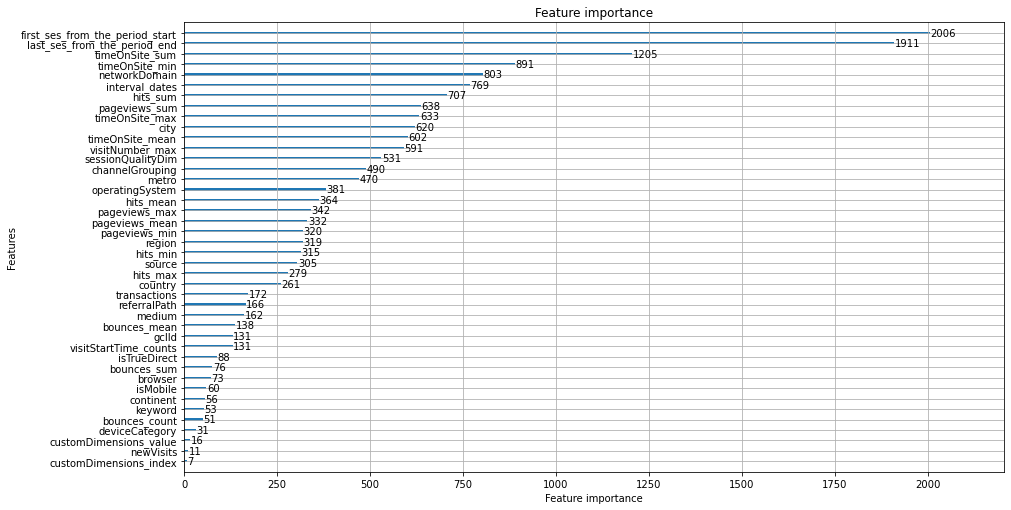

In [15]:
#lets specify thr parametrs first
import lightgbm as lgb
params1 = {'task': 'train',
           'num_iterations': 50, #no of boost round or number of estimators 
           'boosting':'gbdt', #gradient boosted decision tree
           'objective' : 'regression',
           'metric': ['rmse'], #roort mean suqre error
           'is_training_metric': True, #return metric on train data
           'learning_rate' :0.01,
           'max_leaves': 1000,
           'feature_fraction': 0.8, #col sampling
           'bagging_fraction': 0.8, 
           'colsample_bytree': 1.0,
           'max_depth':30, 
           'min_child_samples': 100,
           'reg_alpha': 1, 
           'reg_lambda': 1}

#create train data 
dtrain1 = lgb.Dataset(data = train_x, label = list(train_y.values)) 

#training 
model = lgb.train(params1, dtrain1) 
cv = lgb.cv(params1, dtrain1, nfold= 5, stratified=False, metrics = 'rmse', eval_train_metric= True)
#predicting

pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

lgb.plot_importance(model, figsize=(14.70, 8.27));

In [81]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(train_y.values, pred_train)
print('train_rmse',np.sqrt(train_mse))

test_mse = mean_squared_error(test_y.values, pred_test)
print('test_rmse',np.sqrt(test_mse))

x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': pred_test})
x.to_csv('results/submission_0521_lgbm.csv', index = False)

train_rmse 0.305258151647652
test_rmse 2.108077508142151


### 4.5 CatBoost

In [127]:
train_x[['channelGrouping', 'first_ses_from_the_period_start', 'last_ses_from_the_period_end', 'interval_dates',
         'visitStartTime_counts', 'visitNumber_max', 'isMobile', 'operatingSystem', 'deviceCategory', 'continent',
         'country', 'region', 'city', 'networkDomain', 'bounces_mean', 'hits_sum', 'hits_min', 'hits_max', 'hits_mean', 
         'pageviews_sum', 'pageviews_min', 'pageviews_max', 'pageviews_mean', 'sessionQualityDimMax', 'sessionQualityDimMean',
         'timeOnSite_max', 'timeOnSite_mean', 'timeOnSite_sum', 'transactions', 'campaign', 'source', 'medium', 'referralPath']]

,channelGrouping,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,visitStartTime_counts,visitNumber_max,browser,operatingSystem,isMobile,deviceCategory,...,timeOnSite_mean,transactions,campaign,source,medium,keyword,googleAds,referralPath,isTrueDirect,customDimensions_value
0,4,-0.018261,0.219949,-0.185269,-0.207383,-0.165488,7,6,0,0,...,0.350777,-0.092882,41,110,4,8,1,3571,0,5
1,4,0.875995,-0.677161,-0.185269,-0.207383,-0.165488,7,21,0,0,...,0.736632,-0.092882,41,0,3,8,1,3571,0,5
2,4,-1.326927,1.532793,-0.185269,-0.207383,-0.165488,7,0,1,1,...,0.380746,-0.092882,41,110,4,8,1,3571,0,3
3,4,-0.519916,0.723206,-0.185269,-0.207383,-0.165488,7,21,0,0,...,-0.360993,-0.092882,41,0,3,8,1,3571,0,3
4,7,-1.610472,1.817242,-0.185269,-0.207383,-0.165488,23,6,0,0,...,-0.375978,-0.092882,41,380,5,8,1,2900,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344562,2,0.090795,-0.633399,-0.185269,-0.207383,-0.165488,7,0,1,1,...,0.268362,-0.092882,41,0,3,8,1,3571,1,5
1344563,6,1.115917,-1.661794,-0.185269,-0.207383,-0.165488,7,6,0,0,...,2.115218,6.367849,41,0,3,8,1,3571,0,3
1344564,4,-1.370550,0.832609,-0.185269,-0.207383,-0.165488,7,5,0,0,...,-0.375978,-0.092882,41,110,4,8,1,3571,0,5
1344565,4,-0.236372,-0.305189,-0.185269,-0.207383,-0.165488,7,21,0,0,...,0.140992,-0.092882,41,110,4,8,1,3571,0,3


In [27]:
from catboost import CatBoostRegressor

grid = {'learning_rate': [0.03, 0.05, 0.1],
        'depth': [8, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'bagging_temperature' : [0, 0.2, 0.5]}

model = CatBoostRegressor(iterations = 1000,
                          #metric_period = 50,
                          od_wait = 20,
                          eval_metric='RMSE')

grid_search_result = model.grid_search(grid, 
                                       X = train_x, 
                                       y = train_y, 
                                       cv = 5,
                                       refit = True,
                                       plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.322660322
bestIteration = 125

0:	loss: 0.3226603	best: 0.3226603 (0)	total: 13.5s	remaining: 30m 3s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231627942
bestIteration = 35

1:	loss: 0.3231628	best: 0.3226603 (0)	total: 18.4s	remaining: 20m 24s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236238823
bestIteration = 3

2:	loss: 0.3236239	best: 0.3226603 (0)	total: 20.7s	remaining: 15m 11s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230988267
bestIteration = 49

3:	loss: 0.3230988	best: 0.3226603 (0)	total: 26.9s	remaining: 14m 40s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.323270111
bestIteration = 24

4:	loss: 0.3232701	best: 0.3226603 (0)	total: 30.8s	remaining: 13m 20s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232080941
bestIteration = 64

5:	loss: 0.3232081	best: 0.3226603 (0)	total: 38.1s	remaining: 13m 38s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231862317
bestIteration = 51

6:	loss: 0.3231862	best: 0.3226603 (0)	total: 44.5s	remaining: 13m 33s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231208476
bestIteration = 69

7:	loss: 0.3231208	best: 0.3226603 (0)	total: 52.7s	remaining: 13m 56s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229508022
bestIteration = 60

8:	loss: 0.3229508	best: 0.3226603 (0)	total: 1m	remaining: 14m 6s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232353633
bestIteration = 69

9:	loss: 0.3232354	best: 0.3226603 (0)	total: 1m 8s	remaining: 14m 19s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232664204
bestIteration = 45

10:	loss: 0.3232664	best: 0.3226603 (0)	total: 1m 14s	remaining: 14m 4s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3233285383
bestIteration = 51

11:	loss: 0.3233285	best: 0.3226603 (0)	total: 1m 21s	remaining: 13m 57s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235121174
bestIteration = 57

12:	loss: 0.3235121	best: 0.3226603 (0)	total: 1m 29s	remaining: 13m 55s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231903231
bestIteration = 66

13:	loss: 0.3231903	best: 0.3226603 (0)	total: 1m 36s	remaining: 13m 58s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235751148
bestIteration = 26

14:	loss: 0.3235751	best: 0.3226603 (0)	total: 1m 41s	remaining: 13m 31s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3227134191
bestIteration = 140

15:	loss: 0.3227134	best: 0.3226603 (0)	total: 2m 34s	remaining: 19m 11s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231078607
bestIteration = 30

16:	loss: 0.3231079	best: 0.3226603 (0)	total: 2m 51s	remaining: 19m 47s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231089907
bestIteration = 8

17:	loss: 0.3231090	best: 0.3226603 (0)	total: 3m	remaining: 19m 33s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231716647
bestIteration = 79

18:	loss: 0.3231717	best: 0.3226603 (0)	total: 3m 32s	remaining: 21m 38s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230439136
bestIteration = 66

19:	loss: 0.3230439	best: 0.3226603 (0)	total: 4m 3s	remaining: 23m 17s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232121213
bestIteration = 12

20:	loss: 0.3232121	best: 0.3226603 (0)	total: 4m 13s	remaining: 22m 57s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3227871207
bestIteration = 93

21:	loss: 0.3227871	best: 0.3226603 (0)	total: 4m 50s	remaining: 24m 52s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232131631
bestIteration = 35

22:	loss: 0.3232132	best: 0.3226603 (0)	total: 5m 9s	remaining: 25m 5s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232831229
bestIteration = 12

23:	loss: 0.3232831	best: 0.3226603 (0)	total: 5m 21s	remaining: 24m 48s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3233319789
bestIteration = 58

24:	loss: 0.3233320	best: 0.3226603 (0)	total: 5m 47s	remaining: 25m 30s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231277088
bestIteration = 73

25:	loss: 0.3231277	best: 0.3226603 (0)	total: 6m 26s	remaining: 26m 59s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232521386
bestIteration = 13

26:	loss: 0.3232521	best: 0.3226603 (0)	total: 6m 39s	remaining: 26m 36s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231605364
bestIteration = 119

27:	loss: 0.3231605	best: 0.3226603 (0)	total: 7m 24s	remaining: 28m 19s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236634193
bestIteration = 36

28:	loss: 0.3236634	best: 0.3226603 (0)	total: 7m 46s	remaining: 28m 24s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235110817
bestIteration = 50

29:	loss: 0.3235111	best: 0.3226603 (0)	total: 8m 9s	remaining: 28m 32s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235360582
bestIteration = 40

30:	loss: 0.3235361	best: 0.3226603 (0)	total: 8m 43s	remaining: 29m 14s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236142722
bestIteration = 15

31:	loss: 0.3236143	best: 0.3226603 (0)	total: 9m 2s	remaining: 29m 5s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3239267074
bestIteration = 12

32:	loss: 0.3239267	best: 0.3226603 (0)	total: 9m 20s	remaining: 28m 51s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230916954
bestIteration = 69

33:	loss: 0.3230917	best: 0.3226603 (0)	total: 10m 8s	remaining: 30m 8s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229143039
bestIteration = 59

34:	loss: 0.3229143	best: 0.3226603 (0)	total: 10m 51s	remaining: 31m 2s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.323425614
bestIteration = 18

35:	loss: 0.3234256	best: 0.3226603 (0)	total: 11m 14s	remaining: 30m 54s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232016515
bestIteration = 60

36:	loss: 0.3232017	best: 0.3226603 (0)	total: 12m 5s	remaining: 32m 1s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229396962
bestIteration = 35

37:	loss: 0.3229397	best: 0.3226603 (0)	total: 12m 36s	remaining: 32m 10s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230268767
bestIteration = 40

38:	loss: 0.3230269	best: 0.3226603 (0)	total: 13m 9s	remaining: 32m 23s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3234954548
bestIteration = 60

39:	loss: 0.3234955	best: 0.3226603 (0)	total: 13m 57s	remaining: 33m 9s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235545059
bestIteration = 64

40:	loss: 0.3235545	best: 0.3226603 (0)	total: 14m 49s	remaining: 33m 59s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230662202
bestIteration = 77

41:	loss: 0.3230662	best: 0.3226603 (0)	total: 15m 53s	remaining: 35m 10s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3234598239
bestIteration = 77

42:	loss: 0.3234598	best: 0.3226603 (0)	total: 16m 56s	remaining: 36m 14s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231765363
bestIteration = 149

43:	loss: 0.3231765	best: 0.3226603 (0)	total: 18m 43s	remaining: 38m 43s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232707916
bestIteration = 62

44:	loss: 0.3232708	best: 0.3226603 (0)	total: 19m 28s	remaining: 38m 57s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.322660322
bestIteration = 125

45:	loss: 0.3226603	best: 0.3226603 (0)	total: 19m 42s	remaining: 38m 8s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231627942
bestIteration = 35

46:	loss: 0.3231628	best: 0.3226603 (0)	total: 19m 48s	remaining: 37m 4s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236238823
bestIteration = 3

47:	loss: 0.3236239	best: 0.3226603 (0)	total: 19m 50s	remaining: 35m 57s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230988267
bestIteration = 49

48:	loss: 0.3230988	best: 0.3226603 (0)	total: 19m 57s	remaining: 35m 2s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.323270111
bestIteration = 24

49:	loss: 0.3232701	best: 0.3226603 (0)	total: 20m 2s	remaining: 34m 3s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232080941
bestIteration = 64

50:	loss: 0.3232081	best: 0.3226603 (0)	total: 20m 10s	remaining: 33m 13s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231862317
bestIteration = 51

51:	loss: 0.3231862	best: 0.3226603 (0)	total: 20m 16s	remaining: 32m 22s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231208476
bestIteration = 69

52:	loss: 0.3231208	best: 0.3226603 (0)	total: 20m 25s	remaining: 31m 36s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229508022
bestIteration = 60

53:	loss: 0.3229508	best: 0.3226603 (0)	total: 20m 33s	remaining: 30m 50s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232353633
bestIteration = 69

54:	loss: 0.3232354	best: 0.3226603 (0)	total: 20m 42s	remaining: 30m 6s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232664204
bestIteration = 45

55:	loss: 0.3232664	best: 0.3226603 (0)	total: 20m 48s	remaining: 29m 21s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3233285383
bestIteration = 51

56:	loss: 0.3233285	best: 0.3226603 (0)	total: 20m 55s	remaining: 28m 38s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235121174
bestIteration = 57

57:	loss: 0.3235121	best: 0.3226603 (0)	total: 21m 3s	remaining: 27m 57s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231903231
bestIteration = 66

58:	loss: 0.3231903	best: 0.3226603 (0)	total: 21m 11s	remaining: 27m 17s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235751148
bestIteration = 26

59:	loss: 0.3235751	best: 0.3226603 (0)	total: 21m 16s	remaining: 26m 35s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3227134191
bestIteration = 140

60:	loss: 0.3227134	best: 0.3226603 (0)	total: 22m 12s	remaining: 26m 56s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231078607
bestIteration = 30

61:	loss: 0.3231079	best: 0.3226603 (0)	total: 22m 29s	remaining: 26m 29s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231089907
bestIteration = 8

62:	loss: 0.3231090	best: 0.3226603 (0)	total: 22m 39s	remaining: 25m 53s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231716647
bestIteration = 79

63:	loss: 0.3231717	best: 0.3226603 (0)	total: 23m 12s	remaining: 25m 44s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230439136
bestIteration = 66

64:	loss: 0.3230439	best: 0.3226603 (0)	total: 23m 42s	remaining: 25m 31s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232121213
bestIteration = 12

65:	loss: 0.3232121	best: 0.3226603 (0)	total: 23m 53s	remaining: 24m 58s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3227871207
bestIteration = 93

66:	loss: 0.3227871	best: 0.3226603 (0)	total: 24m 31s	remaining: 24m 53s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232131631
bestIteration = 35

67:	loss: 0.3232132	best: 0.3226603 (0)	total: 24m 49s	remaining: 24m 27s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232831229
bestIteration = 12

68:	loss: 0.3232831	best: 0.3226603 (0)	total: 25m 1s	remaining: 23m 55s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3233319789
bestIteration = 58

69:	loss: 0.3233320	best: 0.3226603 (0)	total: 25m 27s	remaining: 23m 38s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231277088
bestIteration = 73

70:	loss: 0.3231277	best: 0.3226603 (0)	total: 25m 58s	remaining: 23m 25s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232521386
bestIteration = 13

71:	loss: 0.3232521	best: 0.3226603 (0)	total: 26m 9s	remaining: 22m 53s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231605364
bestIteration = 119

72:	loss: 0.3231605	best: 0.3226603 (0)	total: 26m 56s	remaining: 22m 52s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236634193
bestIteration = 36

73:	loss: 0.3236634	best: 0.3226603 (0)	total: 27m 15s	remaining: 22m 28s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235110817
bestIteration = 50

74:	loss: 0.3235111	best: 0.3226603 (0)	total: 27m 40s	remaining: 22m 8s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235360582
bestIteration = 40

75:	loss: 0.3235361	best: 0.3226603 (0)	total: 28m 16s	remaining: 21m 56s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236142722
bestIteration = 15

76:	loss: 0.3236143	best: 0.3226603 (0)	total: 28m 36s	remaining: 21m 33s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3239267074
bestIteration = 12

77:	loss: 0.3239267	best: 0.3226603 (0)	total: 28m 55s	remaining: 21m 8s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230916954
bestIteration = 69

78:	loss: 0.3230917	best: 0.3226603 (0)	total: 29m 43s	remaining: 21m 4s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229143039
bestIteration = 59

79:	loss: 0.3229143	best: 0.3226603 (0)	total: 30m 31s	remaining: 20m 58s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.323425614
bestIteration = 18

80:	loss: 0.3234256	best: 0.3226603 (0)	total: 30m 51s	remaining: 20m 34s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232016515
bestIteration = 60

81:	loss: 0.3232017	best: 0.3226603 (0)	total: 31m 34s	remaining: 20m 24s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229396962
bestIteration = 35

82:	loss: 0.3229397	best: 0.3226603 (0)	total: 32m 3s	remaining: 20m 5s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230268767
bestIteration = 40

83:	loss: 0.3230269	best: 0.3226603 (0)	total: 32m 34s	remaining: 19m 46s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3234954548
bestIteration = 60

84:	loss: 0.3234955	best: 0.3226603 (0)	total: 33m 14s	remaining: 19m 33s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235545059
bestIteration = 64

85:	loss: 0.3235545	best: 0.3226603 (0)	total: 33m 57s	remaining: 19m 20s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230662202
bestIteration = 77

86:	loss: 0.3230662	best: 0.3226603 (0)	total: 34m 49s	remaining: 19m 12s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3234598239
bestIteration = 77

87:	loss: 0.3234598	best: 0.3226603 (0)	total: 35m 40s	remaining: 19m 3s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231765363
bestIteration = 149

88:	loss: 0.3231765	best: 0.3226603 (0)	total: 37m 12s	remaining: 19m 13s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232707916
bestIteration = 62

89:	loss: 0.3232708	best: 0.3226603 (0)	total: 37m 58s	remaining: 18m 59s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.322660322
bestIteration = 125

90:	loss: 0.3226603	best: 0.3226603 (0)	total: 38m 12s	remaining: 18m 28s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231627942
bestIteration = 35

91:	loss: 0.3231628	best: 0.3226603 (0)	total: 38m 17s	remaining: 17m 53s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236238823
bestIteration = 3

92:	loss: 0.3236239	best: 0.3226603 (0)	total: 38m 19s	remaining: 17m 18s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230988267
bestIteration = 49

93:	loss: 0.3230988	best: 0.3226603 (0)	total: 38m 26s	remaining: 16m 45s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.323270111
bestIteration = 24

94:	loss: 0.3232701	best: 0.3226603 (0)	total: 38m 30s	remaining: 16m 12s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232080941
bestIteration = 64

95:	loss: 0.3232081	best: 0.3226603 (0)	total: 38m 38s	remaining: 15m 41s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231862317
bestIteration = 51

96:	loss: 0.3231862	best: 0.3226603 (0)	total: 38m 45s	remaining: 15m 10s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231208476
bestIteration = 69

97:	loss: 0.3231208	best: 0.3226603 (0)	total: 38m 53s	remaining: 14m 40s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229508022
bestIteration = 60

98:	loss: 0.3229508	best: 0.3226603 (0)	total: 39m	remaining: 14m 11s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232353633
bestIteration = 69

99:	loss: 0.3232354	best: 0.3226603 (0)	total: 39m 9s	remaining: 13m 42s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232664204
bestIteration = 45

100:	loss: 0.3232664	best: 0.3226603 (0)	total: 39m 16s	remaining: 13m 13s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3233285383
bestIteration = 51

101:	loss: 0.3233285	best: 0.3226603 (0)	total: 39m 23s	remaining: 12m 44s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235121174
bestIteration = 57

102:	loss: 0.3235121	best: 0.3226603 (0)	total: 39m 30s	remaining: 12m 16s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231903231
bestIteration = 66

103:	loss: 0.3231903	best: 0.3226603 (0)	total: 39m 39s	remaining: 11m 49s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235751148
bestIteration = 26

104:	loss: 0.3235751	best: 0.3226603 (0)	total: 39m 44s	remaining: 11m 21s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3227134191
bestIteration = 140

105:	loss: 0.3227134	best: 0.3226603 (0)	total: 40m 48s	remaining: 11m 9s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231078607
bestIteration = 30

106:	loss: 0.3231079	best: 0.3226603 (0)	total: 41m 6s	remaining: 10m 45s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231089907
bestIteration = 8

107:	loss: 0.3231090	best: 0.3226603 (0)	total: 41m 16s	remaining: 10m 19s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231716647
bestIteration = 79

108:	loss: 0.3231717	best: 0.3226603 (0)	total: 41m 51s	remaining: 9m 59s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230439136
bestIteration = 66

109:	loss: 0.3230439	best: 0.3226603 (0)	total: 42m 22s	remaining: 9m 37s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232121213
bestIteration = 12

110:	loss: 0.3232121	best: 0.3226603 (0)	total: 42m 33s	remaining: 9m 12s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3227871207
bestIteration = 93

111:	loss: 0.3227871	best: 0.3226603 (0)	total: 43m 12s	remaining: 8m 52s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232131631
bestIteration = 35

112:	loss: 0.3232132	best: 0.3226603 (0)	total: 43m 34s	remaining: 8m 29s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232831229
bestIteration = 12

113:	loss: 0.3232831	best: 0.3226603 (0)	total: 43m 47s	remaining: 8m 3s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3233319789
bestIteration = 58

114:	loss: 0.3233320	best: 0.3226603 (0)	total: 44m 15s	remaining: 7m 41s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231277088
bestIteration = 73

115:	loss: 0.3231277	best: 0.3226603 (0)	total: 44m 47s	remaining: 7m 20s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232521386
bestIteration = 13

116:	loss: 0.3232521	best: 0.3226603 (0)	total: 44m 59s	remaining: 6m 55s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231605364
bestIteration = 119

117:	loss: 0.3231605	best: 0.3226603 (0)	total: 45m 52s	remaining: 6m 36s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236634193
bestIteration = 36

118:	loss: 0.3236634	best: 0.3226603 (0)	total: 46m 12s	remaining: 6m 12s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235110817
bestIteration = 50

119:	loss: 0.3235111	best: 0.3226603 (0)	total: 46m 36s	remaining: 5m 49s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235360582
bestIteration = 40

120:	loss: 0.3235361	best: 0.3226603 (0)	total: 47m 11s	remaining: 5m 27s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3236142722
bestIteration = 15

121:	loss: 0.3236143	best: 0.3226603 (0)	total: 47m 32s	remaining: 5m 3s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3239267074
bestIteration = 12

122:	loss: 0.3239267	best: 0.3226603 (0)	total: 47m 51s	remaining: 4m 40s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230916954
bestIteration = 69

123:	loss: 0.3230917	best: 0.3226603 (0)	total: 48m 39s	remaining: 4m 19s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229143039
bestIteration = 59

124:	loss: 0.3229143	best: 0.3226603 (0)	total: 49m 21s	remaining: 3m 56s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.323425614
bestIteration = 18

125:	loss: 0.3234256	best: 0.3226603 (0)	total: 49m 42s	remaining: 3m 33s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232016515
bestIteration = 60

126:	loss: 0.3232017	best: 0.3226603 (0)	total: 50m 28s	remaining: 3m 10s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3229396962
bestIteration = 35

127:	loss: 0.3229397	best: 0.3226603 (0)	total: 51m 1s	remaining: 2m 47s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230268767
bestIteration = 40

128:	loss: 0.3230269	best: 0.3226603 (0)	total: 51m 36s	remaining: 2m 24s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3234954548
bestIteration = 60

129:	loss: 0.3234955	best: 0.3226603 (0)	total: 52m 22s	remaining: 2m


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3235545059
bestIteration = 64

130:	loss: 0.3235545	best: 0.3226603 (0)	total: 53m 11s	remaining: 1m 37s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3230662202
bestIteration = 77

131:	loss: 0.3230662	best: 0.3226603 (0)	total: 54m 9s	remaining: 1m 13s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3234598239
bestIteration = 77

132:	loss: 0.3234598	best: 0.3226603 (0)	total: 55m 4s	remaining: 49.7s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3231765363
bestIteration = 149

133:	loss: 0.3231765	best: 0.3226603 (0)	total: 56m 37s	remaining: 25.4s


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3232707916
bestIteration = 62

134:	loss: 0.3232708	best: 0.3226603 (0)	total: 57m 25s	remaining: 0us
Estimating final quality...


Stopped by overfitting detector  (20 iterations wait)


In [35]:
grid_search_result

{'params': {'bagging_temperature': 0,
  'depth': 8,
  'l2_leaf_reg': 1,
  'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0, 50, 100],
              'test-RMSE-mean': [0.31262457277675615,
               0.30926595220322,
               0.3088373652611456],
              'test-RMSE-std': [0.017219832204078,
               0.019309654803887896,
               0.019709545510680115],
              'train-RMSE-mean': [0.31249789516746046,
               0.2977011740452338,
               0.2915985496683285],
              'train-RMSE-std': [0.004320782129691766,
               0.004648132919798574,
               0.004806073448529715]})}

In [148]:
train_x.columns

Index(['channelGrouping', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates',
       'visitStartTime_counts', 'visitNumber_max', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain',
       'bounces_mean', 'newVisits', 'hits_sum', 'hits_min', 'hits_max',
       'hits_mean', 'pageviews_sum', 'pageviews_min', 'pageviews_max',
       'pageviews_mean', 'sessionQualityDimMin', 'sessionQualityDimMax',
       'sessionQualityDimMean', 'sessionQualityDimSum', 'timeOnSite_sum',
       'timeOnSite_min', 'timeOnSite_max', 'timeOnSite_mean', 'transactions',
       'campaign', 'source', 'medium', 'keyword', 'googleAds', 'referralPath',
       'isTrueDirect', 'customDimensions_value'],
      dtype='object')

In [160]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)


X_train, X_validation, y_train, y_validation = train_test_split(train_x, train_y, test_size=0.15, random_state=1)

clf = CatBoostRegressor(iterations = 1000,
                        learning_rate = 0.03,
                        depth = 8,
                        l2_leaf_reg = 1,
                        eval_metric='RMSE',
                        od_wait = 10)

clf.fit(X_train, y_train,
        eval_set = (X_validation, y_validation),
        use_best_model = True,
        verbose=True)

y_pred_train = clf.predict(X_train)
y_pred_validation = clf.predict(X_validation)
y_pred_test = clf.predict(test_x)

print(f"CatB: RMSE val: {rmse(y_validation, y_pred_validation)}  - RMSE train: {rmse(y_train, y_pred_train)}")

x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': y_pred_test})
x.to_csv('results/submission_0521_catboost_WithValidationSet.csv', index = False)

0:	learn: 0.3127711	test: 0.2967622	best: 0.2967622 (0)	total: 121ms	remaining: 2m
1:	learn: 0.3122908	test: 0.2967424	best: 0.2967424 (1)	total: 283ms	remaining: 2m 21s
2:	learn: 0.3118323	test: 0.2967267	best: 0.2967267 (2)	total: 422ms	remaining: 2m 20s
3:	learn: 0.3113568	test: 0.2964765	best: 0.2964765 (3)	total: 553ms	remaining: 2m 17s
4:	learn: 0.3109081	test: 0.2963568	best: 0.2963568 (4)	total: 691ms	remaining: 2m 17s
5:	learn: 0.3103888	test: 0.2960738	best: 0.2960738 (5)	total: 857ms	remaining: 2m 21s
6:	learn: 0.3099586	test: 0.2959168	best: 0.2959168 (6)	total: 995ms	remaining: 2m 21s
7:	learn: 0.3095630	test: 0.2959104	best: 0.2959104 (7)	total: 1.13s	remaining: 2m 20s
8:	learn: 0.3091638	test: 0.2958102	best: 0.2958102 (8)	total: 1.26s	remaining: 2m 19s
9:	learn: 0.3088096	test: 0.2957350	best: 0.2957350 (9)	total: 1.39s	remaining: 2m 18s
10:	learn: 0.3084326	test: 0.2956306	best: 0.2956306 (10)	total: 1.53s	remaining: 2m 17s
11:	learn: 0.3080684	test: 0.2955228	best: 0.

93:	learn: 0.2940563	test: 0.2902742	best: 0.2902742 (93)	total: 13.2s	remaining: 2m 6s
94:	learn: 0.2939482	test: 0.2902220	best: 0.2902220 (94)	total: 13.3s	remaining: 2m 6s
95:	learn: 0.2938662	test: 0.2902150	best: 0.2902150 (95)	total: 13.4s	remaining: 2m 6s
96:	learn: 0.2938075	test: 0.2902223	best: 0.2902150 (95)	total: 13.6s	remaining: 2m 6s
97:	learn: 0.2937185	test: 0.2901847	best: 0.2901847 (97)	total: 13.7s	remaining: 2m 6s
98:	learn: 0.2936553	test: 0.2901557	best: 0.2901557 (98)	total: 13.8s	remaining: 2m 5s
99:	learn: 0.2936033	test: 0.2901507	best: 0.2901507 (99)	total: 14s	remaining: 2m 5s
100:	learn: 0.2935215	test: 0.2901423	best: 0.2901423 (100)	total: 14.2s	remaining: 2m 6s
101:	learn: 0.2934411	test: 0.2901526	best: 0.2901423 (100)	total: 14.4s	remaining: 2m 6s
102:	learn: 0.2933195	test: 0.2901392	best: 0.2901392 (102)	total: 14.5s	remaining: 2m 6s
103:	learn: 0.2932739	test: 0.2901585	best: 0.2901392 (102)	total: 14.7s	remaining: 2m 6s
104:	learn: 0.2931998	test

In [155]:
clf.get_feature_importance()

array([ 3.56728406, 11.09210622,  8.44488576, 14.68203887,  1.26667715,
        1.92006298,  2.78682327,  0.13408075,  1.54573195,  1.06355022,
        1.29918452,  2.29794529,  2.9234394 ,  1.62685563,  2.89517628,
        0.89106466,  6.02650912,  1.7348324 ,  2.01413553,  4.38580814,
        0.60534303,  2.14313691,  1.554905  ,  0.85718245,  2.93245607,
        0.4177713 , 17.1580181 ,  0.06110598,  0.87427786,  0.35509214,
        0.44251895])

In [ ]:
"""
import catboost as cb

clf = cb.CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

clf.fit(train_x,
        train_y,
        verbose=True)

y_pred_train = clf.predict(train_x)
y_pred_test = clf.predict(test_x)

x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': y_pred_test})
x.to_csv('results/submission_0521_catboost_tune.csv', index = False)
"""

"""
from catboost import CatBoostRegressor

clf = CatBoostRegressor()

clf.fit(train_x, train_y)
    
y_pred_train = clf.predict(train_x)
y_pred_test = clf.predict(test_x)

x = pd.DataFrame(data ={'fullVisitorId': test['fullVisitorId'].astype('str'), 'PredictedLogRevenue': y_pred_test})
x.to_csv('submission_0519_catboost_withoutTune.csv', index = False)
"""

<a id='conclusion'></a>
## 5. Conclusion

- From the dataset, we found that there is only 1.08% completed transaction. Almost 99% of visitor visited the GStore without purchase anything.
- Transaction occur frequently during weekdays.
- Chrome browser is the most favor browser used to surf GStore.
- Most of the users/visitors came from United State.

<a id='References'></a>
## 6. References

**Plotly** library to visualize data in map:
>- [Choropleth Maps in Python](https://plotly.com/python/choropleth-maps/)
- [Continuous Color Scales and Color Bars in Python](https://plotly.com/python/colorscales/)
- [Quick Start: Creating a US State Choropleth Map with Python Plotly](https://wellsr.com/python/creating-python-choropleth-maps-with-plotly/)
- [Choropleth Map with Plotly](https://www.kaggle.com/fabiendaniel/choropleth-map-with-plotly)

**Geopandas** library to visualize data in map:
>- [Creating a GeoDataFrame from a DataFrame with coordinates](https://geopandas.org/gallery/create_geopandas_from_pandas.html)
- [A Beginners Guide to Create a Cloropleth Map in Python using GeoPandas and Matplotlib](https://towardsdatascience.com/a-beginners-guide-to-create-a-cloropleth-map-in-python-using-geopandas-and-matplotlib-9cc4175ab630)
- [Using GeoPandas to Display Data in Spatial Context](https://coolum001.github.io/geopandasdisplay.html)
- [Let’s make a map! Using Geopandas, Pandas and Matplotlib to make a Choropleth map](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d)
- [Creating a Choropleth Map of the World in Python using GeoPandas](https://ramiro.org/notebook/geopandas-choropleth/)

**Pandas** library:
>- [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)
- [Group By: split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)

#### Related Work:
The data we use is from competation in Kaggle, there are some related work we take as reference in our project.

1.) [The winning solution of the competation](https://www.kaggle.com/kostoglot/winning-solution)
	- The is a research done in r language
	- The research propose a unique feature engenering that seperate the date base on time-range:
	  a period of 168 days follow by a gap of 46 days to optimize the prediction
	- The research propose a hurdel model (classification then regression) to solve the prediction problem

2.) [GOOGLE ANALYTICS CUSTOMER REVENUE PREDICTION by Nikhil Bokade](https://medium.com/@nikhil.bokade43/google-analytics-customer-revenue-prediction-f7e4f3861a85) (36th place solutio nof the competation)
    - This research discuss in detail on the data preprocessing & feature engenerring for the model
    
3.) [Gstore Analysis from H.BO's Data Analysis](https://zhuanlan.zhihu.com/p/50525264)
    - In this blog, the author suggest an alternative way to eplore the dataset 
